In [2]:
library(patchwork)
library(tidyverse)
library(ggbeeswarm)
library(gghalves)

theme_fakta <- theme_minimal() +
  theme(
    panel.grid.major.x = element_blank(),
    panel.grid.minor = element_blank(),
    plot.title = element_text(face = "bold", size = 18)
  )

theme_set(theme_fakta)

options(
  knitr.table.format = "html",
  repr.plot.res = 200
)


── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.0     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors


## Parameters

Predefined parameters for nuclear capex calculations, grid and price parameters and settings for overrun scenarios.

In [3]:
path_pattern <- "nuclear-scenarios/2024-04-22-selected/*-complete.csv"
path_pattern_effect <- "nuclear-scenarios/2024-04-15-effect-of/*-complete.csv"

selected_region <- "CZ"

# Values from the reference scenario (as computed in the model).
paid_off_capacity_mw <- 2060
overnight_cost_ref_eur_per_kw <- 6270 * 1.5
decomissioning_cost_ref_eur_per_kw <- .15 * overnight_cost_ref_eur_per_kw
construction_time_ref_years <- 7
discount_rate_ref <- 1.04
# Fixed parameters.
lifetime_years_ref <- 60
lifetime_years <- 60
decomissioning_time_years <- 10
fixed_o_m_eur_per_kw <- 95
variable_o_m_eur_per_mwh <- 10
nuclear_fuel_cost_eur_per_mwh <- 12

# Estimated average power losses in the Czech grid.
grid_losses <- .06

# CZK/EUR exchange rate.
czk_per_eur <- 24.54

# Save SVGs of the generated charts when running the notebook.
save_svgs <- TRUE

overrun_params <- tribble(
  ~ label, ~ overnight_cost, ~ construction_time,
  "6270 €/kW",   0.66666 * overnight_cost_ref_eur_per_kw, construction_time_ref_years,
  "7315 €/kW",  0.77777 * overnight_cost_ref_eur_per_kw, 8,
  "8360 €/kW",  0.88888 * overnight_cost_ref_eur_per_kw, 9,
  "9405 €/kW",  1.0 * overnight_cost_ref_eur_per_kw, 10,
  "10450 €/kW",  1.11111 * overnight_cost_ref_eur_per_kw, 11,
  "11495 €/kW",  1.22222 * overnight_cost_ref_eur_per_kw, 12,
  "12540 €/kW",  1.33333 * overnight_cost_ref_eur_per_kw, 13,
  "13585 €/kW",  1.44444 * overnight_cost_ref_eur_per_kw, 14,
)

color_wind <- "#2291e6"
color_wind_darker <- "#054b81e0"
color_wind_alpha <- "#2291e680"
color_wind_lighter <- "#6ab8f4e0"

color_solar <- "#f2b130"
color_solar_darker <- "#d89000"
color_solar_alpha <- "#f2b13080"

color_demand <- "#e27357"
color_demand_lighter <- "#efab99"
color_demand_alpha <- "#e2735780"
color_demand_darker <- "#80301c"

color_nuclear <- "#036080"
color_nuclear_alpha <- "#03608080"
color_nuclear_lighter <- "#37a0c3"
color_nuclear_darker <- "#023141"

color_smr <- "#3F78A1"
color_smr_lighter <- "#3F78A180"
color_smr_darker <- "#154b71"

color_hydrogen <- "#94e8d9"

color_prices <- "#3e907b"
color_prices_alpha <- "#91c2b8"

color_critical <- "#bd5261a0"

## Helper functions


In [4]:
europe_contexts <- c(
  "technology-driven",
  "nuclear-plus",
  "delayed-interconnections",
  "resistance-to-res"
)

parse_filename <- function(csv_path) {
  contexts_pattern <- paste(europe_contexts, collapse = "|")
  base <- basename(csv_path) |>
    tools::file_path_sans_ext()
  matches <- base |>
    str_match(str_glue("^(.+?)-({contexts_pattern})-complete$"))
  list(
    context = matches[, 3],
    runset = matches[, 2]
  )
}

calculate_system_costs <- function(.data) {
  # 1. Calculate system costs of sources as annual capex + opex.
  source_costs <- .data |>
    filter(stat %in% c("capex_mn_EUR_per_yr", "opex_mn_EUR")) |>
    pivot_wider(names_from = stat, values_from = val) |>
    summarise(
      across(where(is.numeric), sum),
      .by = c(runset, context, name)
    )

  # 2. Add system costs of net imports.
  import_costs <- .data |>
    filter(
      source == "IMPORT_EXPORT",
      stat %in% c("wholesale_expenses_mn_EUR", "wholesale_revenues_mn_EUR")
    ) |>
    select(!source) |>
    pivot_wider(names_from = stat, values_from = val) |>
    transmute(
      runset,
      context,
      name,
      net_import_costs_mn_EUR = wholesale_expenses_mn_EUR - wholesale_revenues_mn_EUR
    )

  # 3. Add interconnectors capex.
  interconnector_costs <- .data |>
    filter(source == "TOTAL", stat == "interconnector_capex_mn_EUR_per_yr") |>
    select(!source) |>
    pivot_wider(names_from = stat, values_from = val) |>
    transmute(
      runset,
      context,
      name,
      interconnector_capex_mn_EUR = interconnector_capex_mn_EUR_per_yr
    )

  # 4. Compute total final demand (net of estimated grid losses).
  total_demand <- .data |>
    filter(source == "TOTAL", stat == "load_TWh") |>
    pivot_wider(names_from = stat, values_from = val) |>
    mutate(final_demand_TWh = load_TWh / (1 + grid_losses)) |>
    select(runset, context, name, final_demand_TWh)

  # 5. Sum the three groups of costs and add total demand.
  left_join(source_costs, import_costs, join_by(runset, context, name)) |>
    left_join(interconnector_costs, join_by(runset, context, name)) |>
    left_join(total_demand, join_by(runset, context, name)) |>
    mutate(
      system_costs_mn_EUR = capex_mn_EUR_per_yr + opex_mn_EUR + net_import_costs_mn_EUR +
        interconnector_capex_mn_EUR
    )
}


In [5]:
costs_fill_scale <- function() {
  scale_fill_viridis_d(
    "Náklady",
    begin = .2,
    end = .9,
    labels = c("Capex", "Interkonektory", "Import", "Opex")
  )
}

# Fix labels of contexts and scenario names.
fix_labels <- function(.data) {
  .data |>
    mutate(
      context = factor(
        context,
        europe_contexts,
        labels = c("Optimální vývoj", "Pokračování jádra v Evropě", "Omezená spolupráce", "Odpor k OZE")
      ),
      name = as.numeric(str_extract(
        name,
        "(?<=-)[[:digit:].]*"
      ))
    )
}

convert_currency <- function(.data, exchange_rate, from = "EUR", to = "CZK", drop_columns = TRUE) {
  from_col <- str_glue("_{from}")
  to_col <- str_glue("_{to}")

  converted <- .data |>
    select(contains(from_col)) |>
    mutate(across(everything(), ~ .x * exchange_rate)) |>
    rename_with(~ str_replace(.x, from_col, to_col))

  if (drop_columns)
    return(
      select(.data, !contains(from_col)) |>
        bind_cols(converted)
    )

  bind_cols(.data, converted)
}


In [6]:
# Time delay in discounting calculations. We use half a year
# as a midpoint approximation for the area under the curve
# over the whole year.
initial_delay_years <- .5

discount_years <- function(discount_rate, num_years, delay = 0) {
  exponents <- seq(from = -delay, by = -1, length.out = num_years)

  sum(discount_rate^exponents)
}

discount_total_costs <- function(total_costs, discount_rate, num_years, delay = 0) {
  discounted_years <- discount_years(discount_rate, num_years, delay)

  total_costs * discounted_years / num_years
}

calculate_total_capex <- function(
  capacity_mw,
  overnight_cost_per_kw,
  decomissioning_cost_per_kw,
  construction_time_years,
  lifetime_years,
  decomissioning_time_years,
  discount_rate
) {
  # Calculate discounted investment costs per kW of installed capacity.
  construction_costs_per_kw <- discount_total_costs(
    overnight_cost_per_kw,
    discount_rate,
    construction_time_years,
    initial_delay_years
  )
  decomissioning_costs_per_kw <- discount_total_costs(
    decomissioning_cost_per_kw,
    discount_rate,
    decomissioning_time_years,
    initial_delay_years + construction_time_years + lifetime_years
  )
  investment_costs_per_kw <- construction_costs_per_kw + decomissioning_costs_per_kw

  investment_costs_per_kw * capacity_mw * 1000
}


calculate_annualized_capex <- function(
  capacity_mw,
  overnight_cost_per_kw,
  decomissioning_cost_per_kw,
  construction_time_years,
  lifetime_years,
  decomissioning_time_years,
  fixed_o_m_per_kw,
  discount_rate
) {
  investment_costs <- calculate_total_capex(
    capacity_mw,
    overnight_cost_per_kw,
    decomissioning_cost_per_kw,
    construction_time_years,
    lifetime_years,
    decomissioning_time_years,
    discount_rate
  )

  lifetime_discounted_years <- discount_years(
    discount_rate, lifetime_years, initial_delay_years + construction_time_years
  )

  annualized_capex <- investment_costs / lifetime_discounted_years

  # Note that O&M costs are not discounted.
  annualized_capex + fixed_o_m_per_kw * capacity_mw * 1000
}

calculate_extra_overrun_costs <- function(
  capacity_mw,
  overnight_cost_eur_per_kw,
  construction_time_years,
  discount_rate
) {
  reference_capex <- calculate_annualized_capex(
    capacity_mw - paid_off_capacity_mw,
    overnight_cost_ref_eur_per_kw,
    decomissioning_cost_ref_eur_per_kw,
    construction_time_ref_years,
    lifetime_years_ref,
    decomissioning_time_years,
    fixed_o_m_eur_per_kw,
    discount_rate_ref
  )

  overrun_capex <- calculate_annualized_capex(
    capacity_mw - paid_off_capacity_mw,
    overnight_cost_eur_per_kw,
    .15 * overnight_cost_eur_per_kw,
    construction_time_years,
    lifetime_years,
    decomissioning_time_years,
    fixed_o_m_eur_per_kw,
    discount_rate
  )

  overrun_capex - reference_capex
}


## Load data and prepare summaries


In [7]:
model_results <- Sys.glob(path_pattern) |>
  map(function(csv_filename) {
    meta <- parse_filename(csv_filename)
    read_csv(csv_filename, show_col_types = FALSE) |>
      filter(season == "Y", region == selected_region) |>
      select(!c(region, season)) |>
      mutate(
        context = meta$context,
        runset = meta$runset,
        .before = "name"
      )
  }) |>
  list_rbind() |>
  fix_labels()

model_results_effect <- Sys.glob(path_pattern_effect) |>
  map(function(csv_filename) {
    meta <- parse_filename(csv_filename)
    read_csv(csv_filename, show_col_types = FALSE) |>
      filter(season == "Y", region == selected_region) |>
      select(!c(region, season)) |>
      mutate(
        context = meta$context,
        runset = meta$runset,
        .before = "name"
      )
  }) |>
  list_rbind() |>
  fix_labels()


In [8]:
nuclear_capacities <- model_results |>
  filter(stat == "capacity_GW", source == "nuclear") |>
  select(runset, context, name, nuclear_GW = val)

model_system_costs <- model_results |>
  calculate_system_costs() |>
  left_join(nuclear_capacities, join_by(runset, context, name)) |>
  mutate(totex_EUR_per_MWh = system_costs_mn_EUR / final_demand_TWh)


nuclear_capacities_effect <- model_results_effect |>
  filter(stat == "capacity_GW", source == "nuclear") |>
  select(runset, context, name, nuclear_GW = val)

model_system_costs_effect <- model_results_effect |>
  calculate_system_costs() |>
  left_join(nuclear_capacities_effect, join_by(runset, context, name)) |>
  mutate(totex_EUR_per_MWh = system_costs_mn_EUR / final_demand_TWh)


## Chart 1: Capex and LCOE heatmaps/contours


In [9]:
#' Calculate the levelized cost of electricity for a source
#' with the given parameters. Result is in currency per MWh.
calculate_lcoe <- function(
  utilization,
  overnight_cost_per_kw,
  decomissioning_cost_per_kw,
  fixed_o_m_per_kw,
  variable_o_m_per_mwh,
  fuel_cost_per_mwh,
  construction_time_years,
  lifetime_years,
  decomissioning_time_years,
  discount_rate
) {
  discounted_capex <- calculate_total_capex(
    # 1 kW of installed capacity is assumed.
    .001,
    overnight_cost_per_kw,
    decomissioning_cost_per_kw,
    construction_time_years,
    lifetime_years,
    decomissioning_time_years,
    discount_rate
  )

  discounted_lifetime_years <-
    discount_years(discount_rate, lifetime_years, initial_delay_years + construction_time_years)
  annual_production_mwh_per_kw <- utilization * 365 * 24 / 1e3
  lifetime_production_mwh <- annual_production_mwh_per_kw * lifetime_years
  discounted_lifetime_production_mwh <- annual_production_mwh_per_kw * discounted_lifetime_years

  opex_per_mwh <-
    (fuel_cost_per_mwh + variable_o_m_per_mwh) +
    fixed_o_m_per_kw / annual_production_mwh_per_kw

  discounted_capex / discounted_lifetime_production_mwh + opex_per_mwh
}


### Chart 1a: Nuclear capex


Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“conversion failure on 'Overnight cost [€/kWe]' in 'mbcsToSbcs': dot substituted for <e2>”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“conversion failure on 'Overnight cost [€/kWe]' in 'mbcsToSbcs': dot substituted for <82>”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“conversion failure on 'Overnight cost [€/kWe]' in 'mbcsToSbcs': dot substituted for <ac>”
Warning message in grid.Call.graphics(C_text, as.graphicsAnnot(x$label), x$x, x$y, :
“conversion failure on 'Overnight cost [€/kWe]' in 'mbcsToSbcs': dot substituted for <e2>”
Warning message in grid.Call.graphics(C_text, as.graphicsAnnot(x$label), x$x, x$y, :
“conversion failure on 'Overnight cost [€/kWe]' in 'mbcsToSbcs': dot substituted for <82>”
Warning message in grid.Call.graphics(C_text, as.graphicsAnnot(x$label), x$x, x$y, :
“conversion failure on 'Overnight cost [€/kW

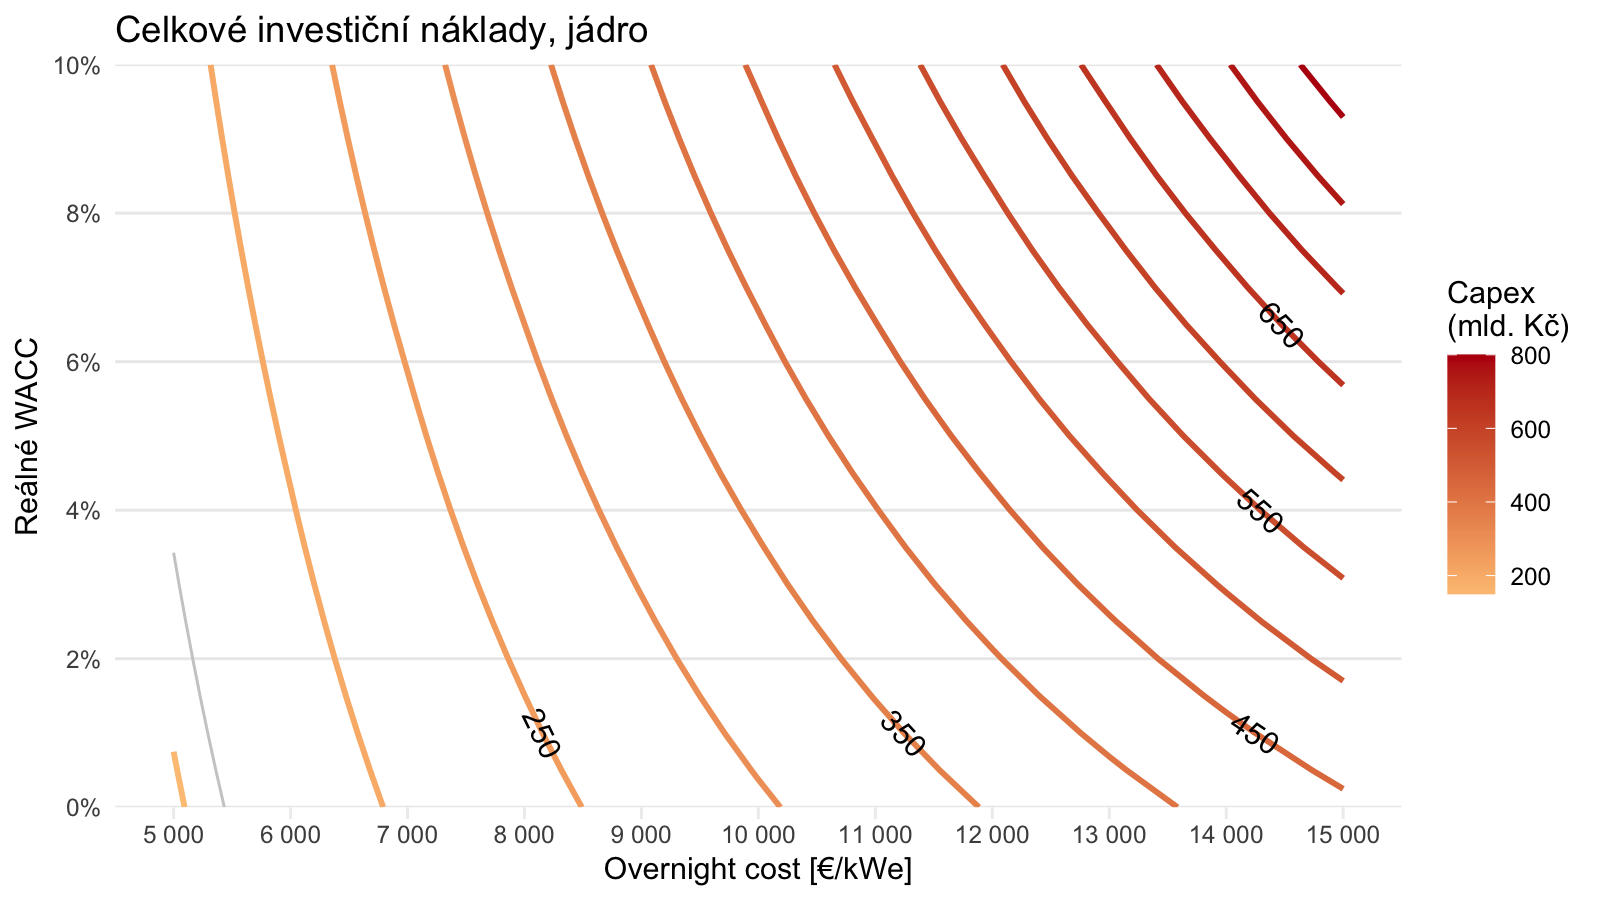

In [10]:
options(repr.plot.width = 8, repr.plot.height = 4.5)

block_size_kW <- 1200

calculate_simple_capex <- function(wacc, capex_per_kw, num_years) {
  discount_rate <- 1 + wacc
  exponents <- seq(from = -.5, by = -1, length.out = num_years)
  capex_mn_per_year <- capex_per_kw * block_size_kW / 1e6

  capex_mn_per_year * num_years / sum(discount_rate^exponents)
}

nuclear_single_capex <- expand_grid(
    wacc = seq(0, .1, .005),
    num_years = seq(5, 15)
  ) |>
  rowwise() |>
  mutate(
    capex_EUR_per_kW = 1000 * num_years,
    total_capex_mn_CZK = czk_per_eur * calculate_simple_capex(
      wacc,
      capex_EUR_per_kW,
      num_years
    )
  )

ggplot(nuclear_single_capex, aes(1000 * num_years, wacc, z = total_capex_mn_CZK)) +
  geom_contour(
    aes(colour = after_stat(level)),
    linewidth = 1,
    breaks = seq(150, 800, 50)
  ) +
  geom_contour(
    colour = "grey80",
    linewidth = .5,
    breaks = c(160)
  ) +
  metR::geom_text_contour(skip = 1) +
  scale_x_continuous(
    "Overnight cost [€/kWe]",
    labels = scales::label_number(),
    breaks = seq(5000, 15000, 1000)
  ) +
  scale_y_continuous(
    "Reálné WACC",
    labels = scales::label_percent(),
    breaks = seq(0, 0.1, .02),
    expand = expansion(0)
  ) +
  scale_colour_gradient(
    "Capex\n(mld. Kč)",
    low = "#fdc483",
    high = "#b80f10"
  ) +
  ggtitle("Celkové investiční náklady, jádro") +
  theme_minimal() +
  theme(
    axis.ticks.length.x = unit(1.5, "mm"),
    axis.ticks.x = element_line(colour = "#eeeeee"),
    panel.grid.major.x = element_blank(),
    panel.grid.minor = element_blank()
  )

if (save_svgs) {
  ggsave("chart-1a-nuclear-capex-contours.svg", width = 8, height = 4.5, create.dir = TRUE)
}


### Chart 1b: Nuclear LCOE


Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“conversion failure on '(€/MWh)' in 'mbcsToSbcs': dot substituted for <e2>”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“conversion failure on '(€/MWh)' in 'mbcsToSbcs': dot substituted for <82>”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“conversion failure on '(€/MWh)' in 'mbcsToSbcs': dot substituted for <ac>”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“conversion failure on '(€/MWh)' in 'mbcsToSbcs': dot substituted for <e2>”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“conversion failure on '(€/MWh)' in 'mbcsToSbcs': dot substituted for <82>”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“conversion failure on '(€/MWh)' in 'mbcsToSbcs': dot substituted for <ac>”
Warning message in grid.Call(C_textBounds, as.graphi

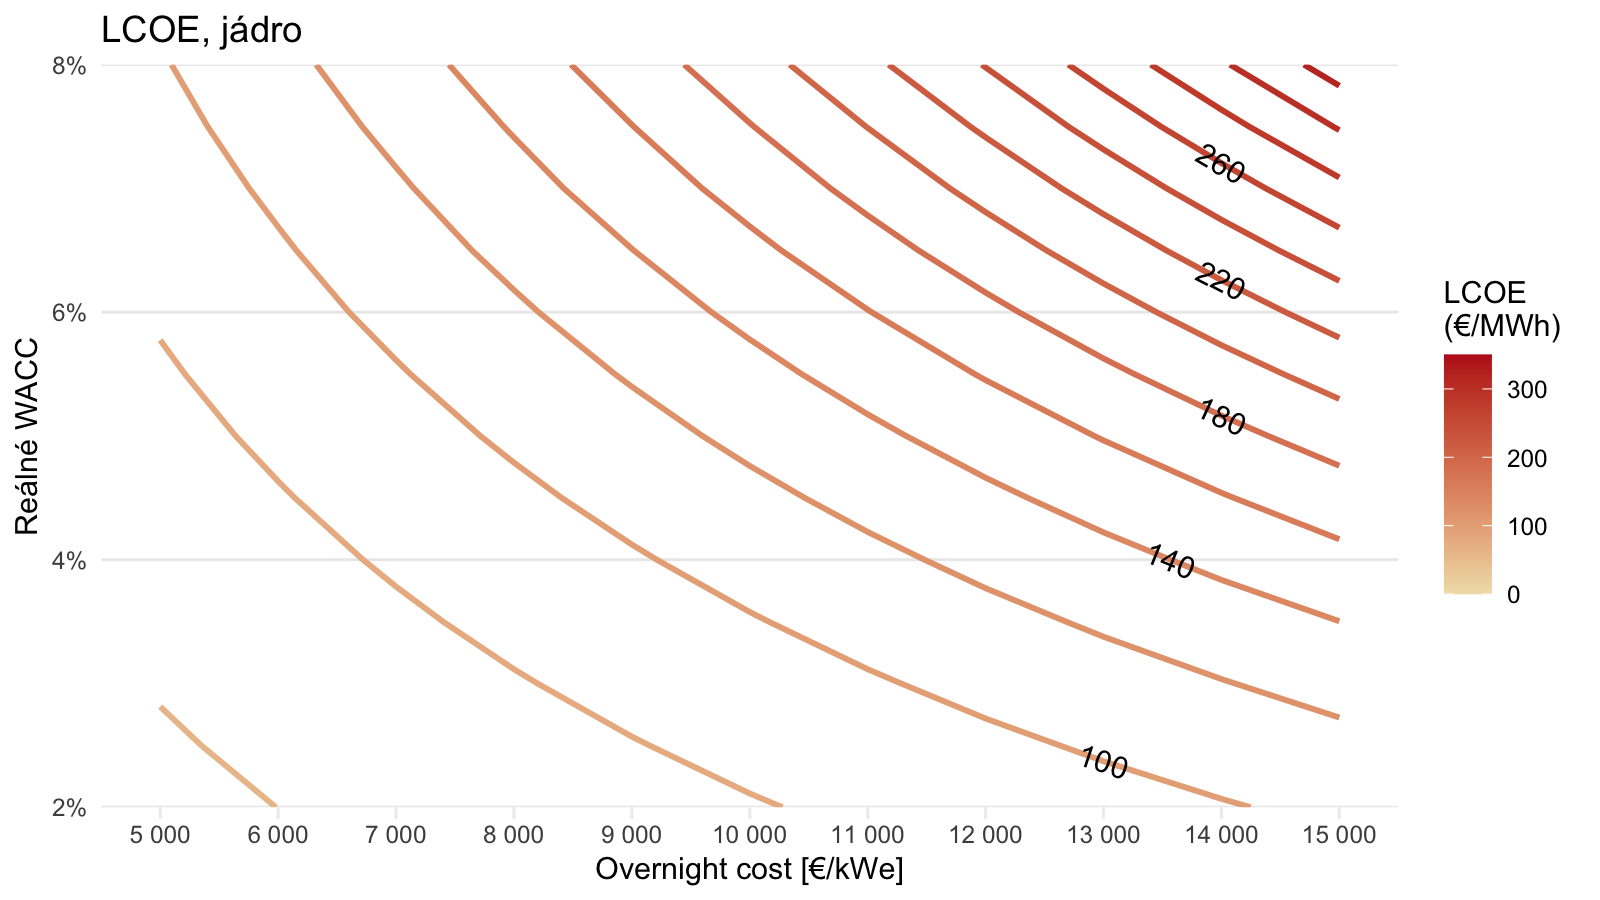

In [11]:
options(repr.plot.width = 8, repr.plot.height = 4.5)

nuclear_average_utilization <- .85

nuclear_lcoe <- expand_grid(
    wacc = seq(.02, .08, .005),
    num_years = seq(5, 15)
  ) |>
  rowwise() |>
  mutate(
    capex_EUR_per_kW = 1000 * num_years,
    lcoe_EUR_per_MWh = calculate_lcoe(
      nuclear_average_utilization,
      capex_EUR_per_kW,
      .15 * capex_EUR_per_kW,
      fixed_o_m_eur_per_kw,
      variable_o_m_eur_per_mwh,
      nuclear_fuel_cost_eur_per_mwh,
      num_years,
      60,
      10,
      1 + wacc
    )
  )

ggplot(nuclear_lcoe, aes(capex_EUR_per_kW, wacc, z = lcoe_EUR_per_MWh)) +
  geom_contour(
    aes(colour = after_stat(level)),
    linewidth = 1,
    # breaks = seq(150, 800, 50)
  ) +
  metR::geom_text_contour(skip = 1) +
  scale_x_continuous(
    "Overnight cost [€/kWe]",
    labels = scales::label_number(),
    breaks = seq(5000, 15000, 1000)
  ) +
  scale_y_continuous(
    "Reálné WACC",
    labels = scales::label_percent(),
    breaks = seq(0, 0.1, .02),
    expand = expansion(0)
  ) +
  scale_colour_gradient(
    "LCOE\n(€/MWh)",
    low = "#f0e0b6",
    high = "#bb1c1c",
    limits = c(0, 350)
  ) +
  ggtitle("LCOE, jádro") +
  theme_minimal() +
  theme(
    axis.ticks.length.x = unit(1.5, "mm"),
    axis.ticks.x = element_line(colour = "#eeeeee"),
    panel.grid.major.x = element_blank(),
    panel.grid.minor = element_blank()
  )

if (save_svgs) {
  ggsave("chart-1b-nuclear-lcoe-contours.svg", width = 8, height = 4.5, create.dir = TRUE)
}


### Chart 1c: Solar PV LCOE


Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“conversion failure on '(€/MWh)' in 'mbcsToSbcs': dot substituted for <e2>”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“conversion failure on '(€/MWh)' in 'mbcsToSbcs': dot substituted for <82>”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“conversion failure on '(€/MWh)' in 'mbcsToSbcs': dot substituted for <ac>”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“conversion failure on '(€/MWh)' in 'mbcsToSbcs': dot substituted for <e2>”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“conversion failure on '(€/MWh)' in 'mbcsToSbcs': dot substituted for <82>”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“conversion failure on '(€/MWh)' in 'mbcsToSbcs': dot substituted for <ac>”
Warning message in grid.Call(C_textBounds, as.graphi

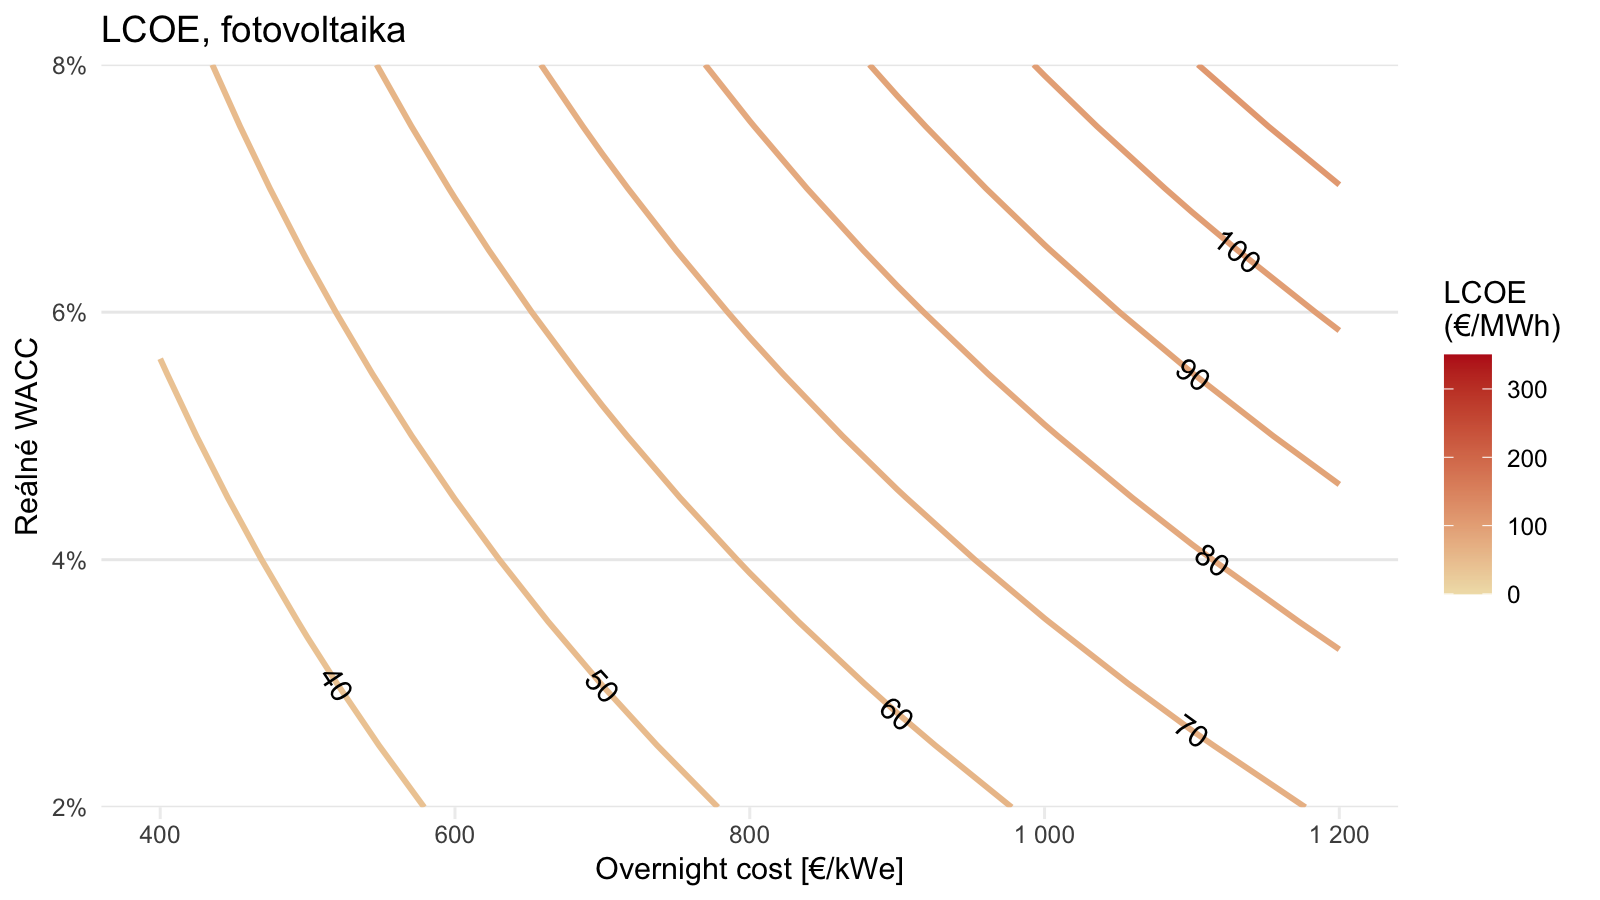

In [12]:
options(repr.plot.width = 8, repr.plot.height = 4.5)

solar_average_utilization <- .12

solar_lcoe <- expand_grid(
    wacc = seq(.02, .08, .005),
    capex_EUR_per_kW = seq(400, 1200, 100)
  ) |>
  rowwise() |>
  mutate(
    lcoe_EUR_per_MWh = calculate_lcoe(
      solar_average_utilization,
      capex_EUR_per_kW,
      .05 * capex_EUR_per_kW,
      fixed_o_m_per_kw = 11.5,
      variable_o_m_per_mwh = 0,
      fuel_cost_per_mwh = 0,
      construction_time_years = 1,
      lifetime_years = 25,
      decomissioning_time_years = 1,
      discount_rate = 1 + wacc
    )
  )

ggplot(solar_lcoe, aes(capex_EUR_per_kW, wacc, z = lcoe_EUR_per_MWh)) +
  geom_contour(
    aes(colour = after_stat(level)),
    linewidth = 1,
    # breaks = seq(150, 800, 50)
  ) +
  metR::geom_text_contour(skip = 0) +
  scale_x_continuous(
    "Overnight cost [€/kWe]",
    labels = scales::label_number(),
    # breaks = seq(400, 1200, 200)
  ) +
  scale_y_continuous(
    "Reálné WACC",
    labels = scales::label_percent(),
    breaks = seq(0, 0.1, .02),
    expand = expansion(0)
  ) +
  scale_colour_gradient(
    "LCOE\n(€/MWh)",
    low = "#f0e0b6",
    high = "#bb1c1c",
    limits = c(0, 350)
  ) +
  ggtitle("LCOE, fotovoltaika") +
  theme_minimal() +
  theme(
    axis.ticks.length.x = unit(1.5, "mm"),
    axis.ticks.x = element_line(colour = "#eeeeee"),
    panel.grid.major.x = element_blank(),
    panel.grid.minor = element_blank()
  )

if (save_svgs) {
  ggsave("chart-1c-solar-lcoe-contours.svg", width = 8, height = 4.5, create.dir = TRUE)
}


### Chart 1d: Wind LCOE


Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“conversion failure on '(€/MWh)' in 'mbcsToSbcs': dot substituted for <e2>”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“conversion failure on '(€/MWh)' in 'mbcsToSbcs': dot substituted for <82>”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“conversion failure on '(€/MWh)' in 'mbcsToSbcs': dot substituted for <ac>”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“conversion failure on '(€/MWh)' in 'mbcsToSbcs': dot substituted for <e2>”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“conversion failure on '(€/MWh)' in 'mbcsToSbcs': dot substituted for <82>”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“conversion failure on '(€/MWh)' in 'mbcsToSbcs': dot substituted for <ac>”
Warning message in grid.Call(C_textBounds, as.graphi

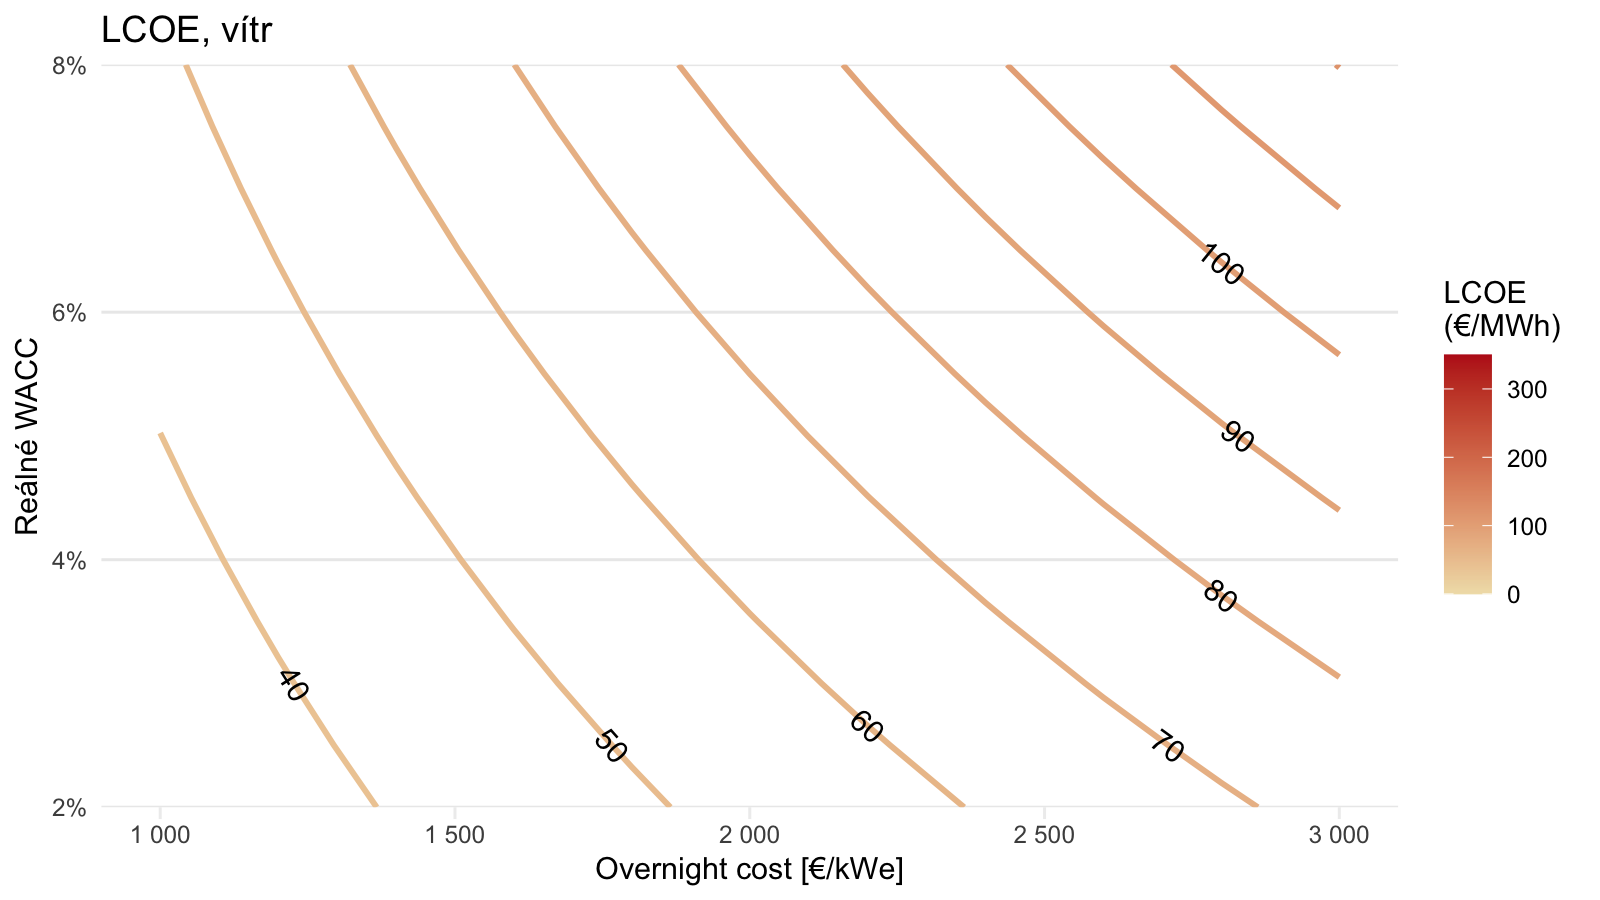

In [13]:
options(repr.plot.width = 8, repr.plot.height = 4.5)

wind_average_utilization <- .30

wind_lcoe <- expand_grid(
    wacc = seq(.02, .08, .005),
    capex_EUR_per_kW = seq(1000, 3000, 200)
  ) |>
  rowwise() |>
  mutate(
    lcoe_EUR_per_MWh = calculate_lcoe(
      wind_average_utilization,
      capex_EUR_per_kW,
      .05 * capex_EUR_per_kW,
      fixed_o_m_per_kw = 33,
      variable_o_m_per_mwh = 0,
      fuel_cost_per_mwh = 0,
      construction_time_years = 1,
      lifetime_years = 25,
      decomissioning_time_years = 1,
      discount_rate = 1 + wacc
    )
  )

ggplot(wind_lcoe, aes(capex_EUR_per_kW, wacc, z = lcoe_EUR_per_MWh)) +
  geom_contour(
    aes(colour = after_stat(level)),
    linewidth = 1,
    # breaks = seq(150, 800, 50)
  ) +
  metR::geom_text_contour(skip = 0) +
  scale_x_continuous(
    "Overnight cost [€/kWe]",
    labels = scales::label_number(),
    # breaks = seq(1000, 3000, 500)
  ) +
  scale_y_continuous(
    "Reálné WACC",
    labels = scales::label_percent(),
    breaks = seq(0, 0.1, .02),
    expand = expansion(0)
  ) +
  scale_colour_gradient(
    "LCOE\n(€/MWh)",
    low = "#f0e0b6",
    high = "#bb1c1c",
    limits = c(0, 350)
  ) +
  ggtitle("LCOE, vítr") +
  theme_minimal() +
  theme(
    axis.ticks.length.x = unit(1.5, "mm"),
    axis.ticks.x = element_line(colour = "#eeeeee"),
    panel.grid.major.x = element_blank(),
    panel.grid.minor = element_blank()
  )

if (save_svgs) {
  ggsave("chart-1d-wind-lcoe-contours.svg", width = 8, height = 4.5, create.dir = TRUE)
}


## Chart 2: System costs overview


In [14]:
#' This function allows overriding the discount rate
#' for specific scenarios.
get_scenario_discount_rate <- function(name) {
  return(discount_rate_ref)
  # return(1.08)
  # case_when(
  #   name %in% c("+4", "+4'") ~ 1.05,
  #   name == "+3" ~ 1.0466,
  #   .default = 1.04
  # )
}

calculate_overrun_scenarios <- function(.data, params) {
  compute_scenarios <- function(nuclear_GW, name) {
    as.list(params) |>
      pmap(
        \(label, overnight_cost, construction_time) tibble(
          overrun = label,
          extra_capex_mn_EUR_per_yr = calculate_extra_overrun_costs(
            1000 * nuclear_GW,
            overnight_cost,
            construction_time,
            get_scenario_discount_rate(name)
          ) / 1e6
        )
      ) |>
      list_rbind()
  }

  .data |>
    mutate(
      overrun = pmap(
        list(nuclear_GW, name),
        compute_scenarios
      )
    ) |>
    unnest(overrun) |>
    mutate(
      capex_mn_EUR_per_yr = capex_mn_EUR_per_yr + extra_capex_mn_EUR_per_yr,
      system_costs_mn_EUR = system_costs_mn_EUR + extra_capex_mn_EUR_per_yr
    )
}


## Chart 2a: Simple plots for different runs


In [15]:
calculate_overrun_scenarios_wacc <- function(.data, params, wacc) {
  params_with_wacc <- expand_grid(
    df = params,
    wacc = wacc
  ) |>
    unnest(df)

  compute_scenarios <- function(nuclear_GW) {
    as.list(params_with_wacc) |>
      pmap(
        \(label, overnight_cost, construction_time, wacc) tibble(
          overrun = label,
          wacc = wacc,
          extra_capex_mn_EUR_per_yr = calculate_extra_overrun_costs(
            1000 * nuclear_GW,
            overnight_cost,
            construction_time,
            1 + wacc
          ) / 1e6
        )
      ) |>
      list_rbind()
  }

  .data |>
    mutate(
      overrun = map(
        nuclear_GW,
        compute_scenarios
      )
    ) |>
    unnest(overrun) |>
    mutate(
      capex_mn_EUR_per_yr = capex_mn_EUR_per_yr + extra_capex_mn_EUR_per_yr,
      system_costs_mn_EUR = system_costs_mn_EUR + extra_capex_mn_EUR_per_yr
    )
}


### A: Wind

Warning message:
“Using `size` aesthetic for lines was deprecated in ggplot2 3.4.0.
ℹ Please use `linewidth` instead.”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“conversion failure on '-10 €' in 'mbcsToSbcs': dot substituted for <e2>”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“conversion failure on '-10 €' in 'mbcsToSbcs': dot substituted for <82>”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“conversion failure on '-10 €' in 'mbcsToSbcs': dot substituted for <ac>”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“conversion failure on '-5 €' in 'mbcsToSbcs': dot substituted for <e2>”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“conversion failure on '-5 €' in 'mbcsToSbcs': dot substituted for <82>”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“conversion failure o

[1] 24.64989


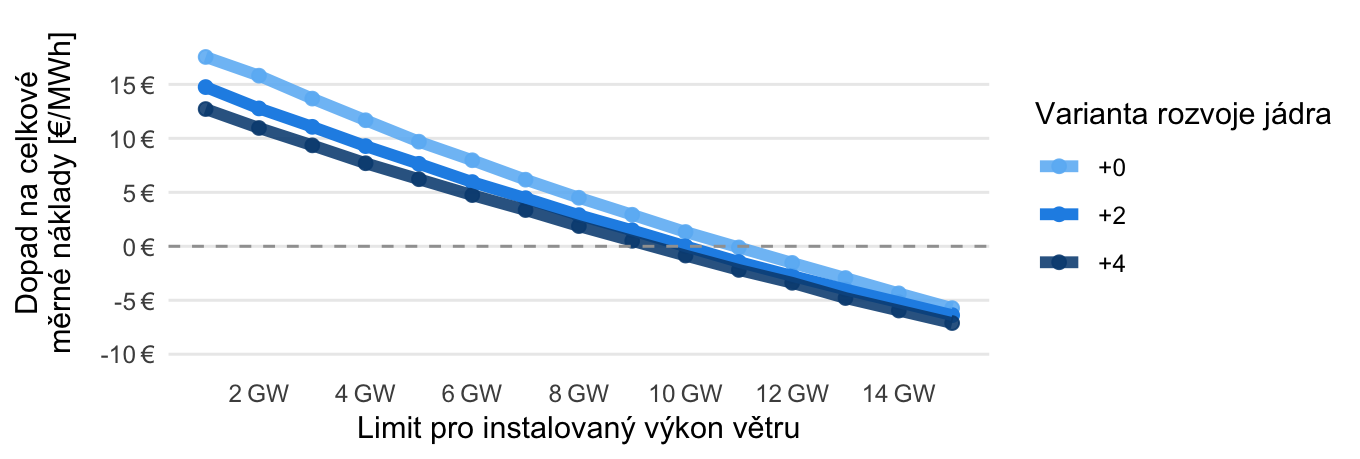

In [16]:
# options(repr.plot.width = 5, repr.plot.height = 2.3)  # A
options(repr.plot.width = 6.8, repr.plot.height = 2.3)  # B

reference_system_costs <- model_system_costs_effect |>
  filter(runset == "effect-of-wind-2" & context == "Omezená spolupráce") |>
  filter(name == "10")

reference_system_costs <- reference_system_costs |>
  calculate_overrun_scenarios_wacc(
    filter(overrun_params, label == "9405 €/kW"),
    wacc = .04
  ) |>
  mutate(totex_EUR_per_MWh = system_costs_mn_EUR / final_demand_TWh) |>
  mutate(overrun = fct_inorder(overrun))

selected_system_costs <- model_system_costs_effect |>
  # filter(runset == "effect-of-wind-2" & context == "Omezená spolupráce") |>  # A
  filter((runset == "effect-of-wind-4" | runset == "effect-of-wind-2" | runset == "effect-of-wind-0") & context == "Omezená spolupráce") |>  # B
  calculate_overrun_scenarios_wacc(
    filter(overrun_params, label == "9405 €/kW"),
    wacc = .04
  ) |>
  mutate(
    totex_EUR_per_MWh = system_costs_mn_EUR / final_demand_TWh,
    totex_increase_EUR_per_MWh = totex_EUR_per_MWh - reference_system_costs$totex_EUR_per_MWh
  ) |>
  mutate(overrun = fct_inorder(overrun))

selected_system_costs |>
  ggplot(aes(name, totex_increase_EUR_per_MWh)) +
  geom_point(
    aes(colour = runset),
    shape = 19,
    size = 2,
    data = selected_system_costs |> filter(overrun == "9405 €/kW"),
  ) +
  geom_line(
    aes(colour = runset, group = runset),
    linetype = "solid",
    size = 2,
    data = selected_system_costs |> filter(overrun == "9405 €/kW"),
  ) +
  scale_x_continuous(
    "Limit pro instalovaný výkon větru",
    n.breaks = 8,
    labels = scales::label_number(suffix = " GW")
  ) +
  scale_colour_manual(
    name = "Varianta rozvoje jádra",
    labels = c("+0", "+2", "+4"),
    values = c(
      # color_wind  # A
      color_wind_lighter, color_wind, color_wind_darker  # B
    ),
  ) +
  # theme(legend.position = "none") +  # A
  geom_hline(yintercept = 0, color = "#a0a0a0", linetype = "dashed") +
  scale_y_continuous(
    "Dopad na celkové\nměrné náklady [€/MWh]",
    labels = scales::label_number(suffix = " €"),
    breaks = seq(-10, 15, 5),
    limits = c(-10, 20),
  )
print(max(selected_system_costs$totex_increase_EUR_per_MWh) - min(selected_system_costs$totex_increase_EUR_per_MWh))


if (save_svgs) {
  # ggsave("effect-of-wind-A.svg", width = 5, height = 2.3, create.dir = TRUE)  # A
  ggsave("effect-of-wind-B.svg", width = 6.8, height = 2.3, create.dir = TRUE)  # B
}


### A1: Wind CfDs

Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“conversion failure on '60 €' in 'mbcsToSbcs': dot substituted for <e2>”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“conversion failure on '60 €' in 'mbcsToSbcs': dot substituted for <82>”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“conversion failure on '60 €' in 'mbcsToSbcs': dot substituted for <ac>”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“conversion failure on '80 €' in 'mbcsToSbcs': dot substituted for <e2>”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“conversion failure on '80 €' in 'mbcsToSbcs': dot substituted for <82>”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“conversion failure on '80 €' in 'mbcsToSbcs': dot substituted for <ac>”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), 

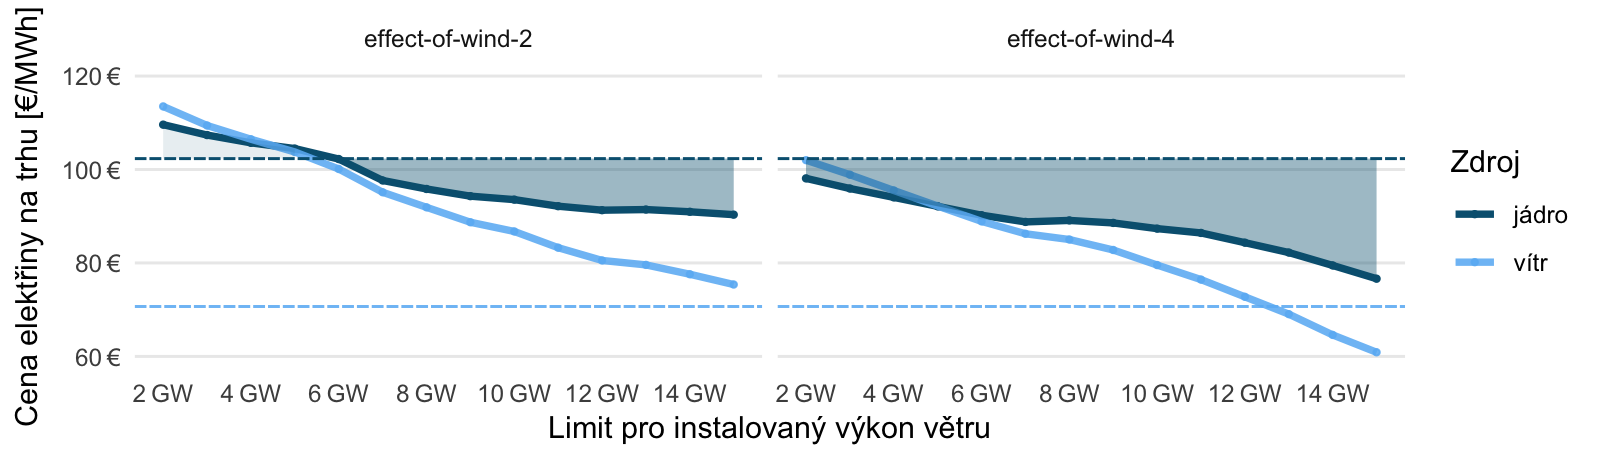

In [17]:
options(repr.plot.width = 8, repr.plot.height = 2.3) # B

selected_system_costs <- model_results_effect |>
  filter((runset == "effect-of-wind-4" | runset == "effect-of-wind-2") & context == "Omezená spolupráce")


wholesale_price <- selected_system_costs |>
  filter(
    (stat == "wholesale_revenues_mn_EUR" | stat == "production_TWh") &
      (source == "onshore" | source == "nuclear") &
      name != "1"
  ) |>
  pivot_wider(names_from = stat, values_from = val) |>
  summarise(
    across(where(is.numeric), sum),
    .by = c(runset, name, source)
  ) |>
  mutate(
    wholesale_price_EUR_MWh = wholesale_revenues_mn_EUR / production_TWh
  )

# Simplified investment models to pay back the full loan in the timeframe of the CfD / state loan.
strike_price_nuclear <- 102.33 # Assuming 7315 €/kWe, 8 years of construction and 30 years of operation (to pay back the loan)
strike_price_wind <- 70.68  # Assuming 1550 €/kW, 1 year of construction and 15 years of CfD (to pay back the load).

wholesale_price |>
  ggplot(aes(name, wholesale_price_EUR_MWh)) +
  geom_point(
    aes(colour = source),
    shape = 19,
    size = 0.75
  ) +
  geom_line(
    aes(colour = source, group = source),
    linetype = "solid",
    size = 1.25
  ) +
  geom_ribbon(
    aes(ymin = strike_price_nuclear, ymax = wholesale_price_EUR_MWh),
    fill = color_nuclear,
    alpha = 0.1,
    data = wholesale_price |> filter(source == "nuclear" & wholesale_price_EUR_MWh > strike_price_nuclear)
  ) +
  geom_ribbon(
    aes(ymin = strike_price_nuclear, ymax = wholesale_price_EUR_MWh),
    fill = color_nuclear,
    alpha = 0.4,
    data = wholesale_price |> filter(source == "nuclear" & wholesale_price_EUR_MWh < strike_price_nuclear)
  ) +
  scale_x_continuous(
    "Limit pro instalovaný výkon větru",
    n.breaks = 8,
    labels = scales::label_number(suffix = " GW"),
  ) +
  scale_colour_manual(
    name = "Zdroj",
    labels = c("jádro", "vítr"),
    values = c(color_nuclear, color_wind_lighter),
  ) +
  scale_fill_manual(values = c("red", "green"), name = "fill") +
  geom_hline(yintercept = strike_price_nuclear, color = color_nuclear, size = 0.5, linetype = "41") +
  geom_hline(yintercept = strike_price_wind, color = color_wind_lighter, size = 0.5, linetype = "41") +
  facet_grid(cols = vars(runset)) +
  scale_y_continuous(
    "Cena elektřiny na trhu [€/MWh]",
    labels = scales::label_number(suffix = " €"),
    limits = c(60, 120),
  )

if (save_svgs) {
  ggsave("effect-of-CfDs.svg", width = 8, height = 2.3, create.dir = TRUE)
}


### B: Solar

Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“conversion failure on '-10 €' in 'mbcsToSbcs': dot substituted for <e2>”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“conversion failure on '-10 €' in 'mbcsToSbcs': dot substituted for <82>”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“conversion failure on '-10 €' in 'mbcsToSbcs': dot substituted for <ac>”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“conversion failure on '-5 €' in 'mbcsToSbcs': dot substituted for <e2>”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“conversion failure on '-5 €' in 'mbcsToSbcs': dot substituted for <82>”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“conversion failure on '-5 €' in 'mbcsToSbcs': dot substituted for <ac>”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label

[1] 6.90319


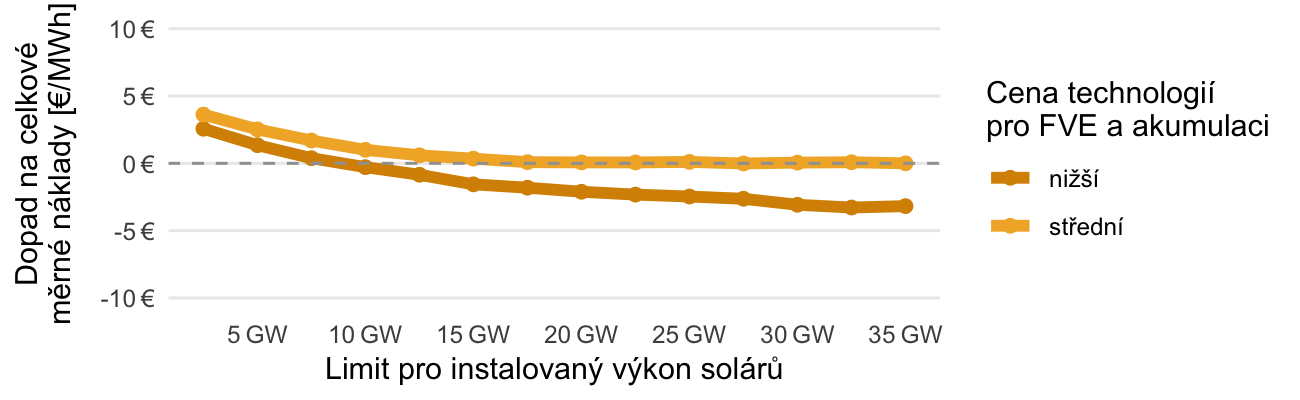

In [18]:
# options(repr.plot.width = 5, repr.plot.height = 2)  # A
options(repr.plot.width = 6.5, repr.plot.height = 2)  # B

reference_system_costs <- model_system_costs_effect |>
  filter(runset == "effect-of-solar-2" & context == "Omezená spolupráce") |>
  filter(name == "35")

reference_system_costs <- reference_system_costs |>
  calculate_overrun_scenarios_wacc(
    filter(overrun_params, label == "9405 €/kW"),
    wacc = .04
  ) |>
  mutate(totex_EUR_per_MWh = system_costs_mn_EUR / final_demand_TWh) |>
  mutate(overrun = fct_inorder(overrun))

selected_system_costs <- model_system_costs_effect |>
  # filter(runset == "effect-of-solar-2" & context == "Omezená spolupráce") |>  # A
  filter((runset == "effect-of-cheaper-solar-2" & context == "Omezená spolupráce") | (runset == "effect-of-solar-2" & context == "Omezená spolupráce")) |>  # B
  calculate_overrun_scenarios_wacc(
    filter(overrun_params, label == "9405 €/kW"),
    wacc = .04
  ) |>
  mutate(
    totex_EUR_per_MWh = system_costs_mn_EUR / final_demand_TWh,
    totex_increase_EUR_per_MWh = totex_EUR_per_MWh - reference_system_costs$totex_EUR_per_MWh
  ) |>
  mutate(overrun = fct_inorder(overrun))

selected_system_costs |>
  ggplot(aes(name, totex_increase_EUR_per_MWh)) +
  geom_point(
    aes(color = runset),
    data = selected_system_costs |> filter(overrun == "9405 €/kW"),
    shape = 19,
    size = 2
  ) +
  geom_line(
    aes(group = runset, color = runset),
    size = 2,
    data = selected_system_costs |> filter(overrun == "9405 €/kW"),
  ) +
  scale_x_continuous(
    "Limit pro instalovaný výkon solárů",
    labels = scales::label_number(suffix = " GW"),
    n.breaks = 8,
  ) +
  scale_colour_manual(
    name = "Cena technologií\npro FVE a akumulaci",
    labels = c("nižší", "střední"),
    values = c(
      # color_solar  # A
      color_solar_darker, color_solar  # B
    ),
  ) +
  # theme(legend.position = "none") +  # A
  geom_hline(yintercept = 0, color = "#a0a0a0", linetype = "dashed") +
  scale_y_continuous(
    "Dopad na celkové\nměrné náklady [€/MWh]",
    labels = scales::label_number(suffix = " €"),
    breaks = seq(-10, 10, 5),
    limits = c(-10, 10),
  )

print(max(selected_system_costs$totex_increase_EUR_per_MWh) - min(selected_system_costs$totex_increase_EUR_per_MWh))

if (save_svgs) {
  # ggsave("effect-of-solar-A.svg", width = 5, height = 2, create.dir = TRUE)  # A
  ggsave("effect-of-solar-B.svg", width = 6.5, height = 2, create.dir = TRUE)  # B
}


### C: Demand

Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“conversion failure on '-10 €' in 'mbcsToSbcs': dot substituted for <e2>”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“conversion failure on '-10 €' in 'mbcsToSbcs': dot substituted for <82>”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“conversion failure on '-10 €' in 'mbcsToSbcs': dot substituted for <ac>”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“conversion failure on '-5 €' in 'mbcsToSbcs': dot substituted for <e2>”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“conversion failure on '-5 €' in 'mbcsToSbcs': dot substituted for <82>”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“conversion failure on '-5 €' in 'mbcsToSbcs': dot substituted for <ac>”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label

[1] 17.06985


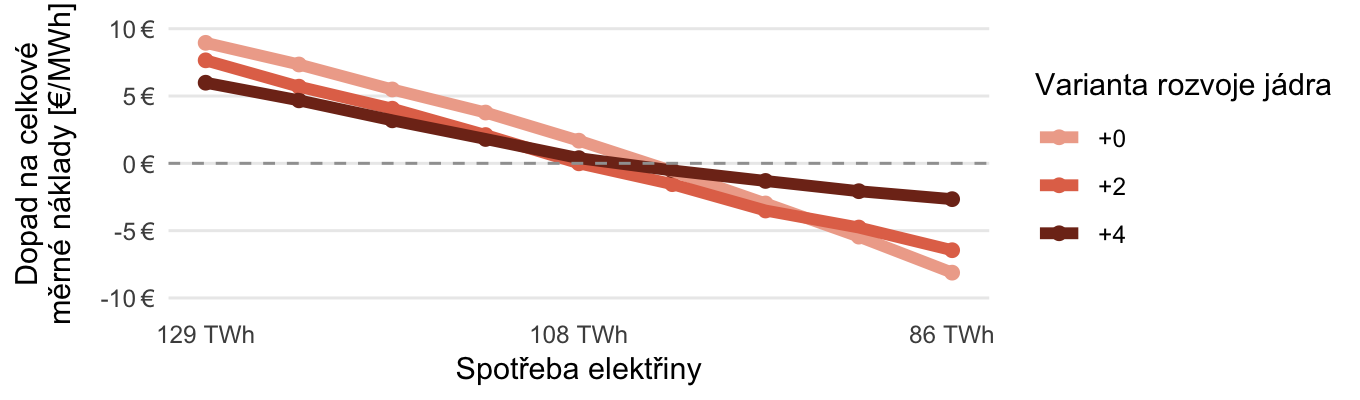

In [19]:
# options(repr.plot.width = 5, repr.plot.height = 2)  # A
options(repr.plot.width = 6.8, repr.plot.height = 2)  # B

demand_labels <- function(breaks) {
  return (sprintf("%.0f TWh", (breaks/100) * 107.5))
}

reference_system_costs <- model_system_costs_effect |>
  filter(runset == "effect-of-demand-2" & context == "Optimální vývoj") |>
  filter(name == "100")

  reference_system_costs <- reference_system_costs |>
    calculate_overrun_scenarios_wacc(
      filter(overrun_params, label == "9405 €/kW"),
      wacc = .04
    ) |>
    mutate(totex_EUR_per_MWh = system_costs_mn_EUR / final_demand_TWh) |>
    mutate(overrun = fct_inorder(overrun))

selected_system_costs <- model_system_costs_effect |>
  # filter(runset == "effect-of-demand-2" & context == "Optimální vývoj") |>  # A
  filter((runset == "effect-of-demand-2" | runset == "effect-of-demand-0" | runset == "effect-of-demand-4") & context == "Optimální vývoj") |>  # B
  calculate_overrun_scenarios_wacc(
    filter(overrun_params, label == "9405 €/kW"),
    wacc = .04
  ) |>
  mutate(
    totex_EUR_per_MWh = system_costs_mn_EUR / final_demand_TWh,
    totex_increase_EUR_per_MWh = totex_EUR_per_MWh - reference_system_costs$totex_EUR_per_MWh
  ) |>
  mutate(overrun = fct_inorder(overrun))

selected_system_costs |>
  ggplot(aes(name, totex_increase_EUR_per_MWh)) +
  geom_point(
    aes(colour = runset),
    shape = 19,
    size = 2,
    data = selected_system_costs |> filter(overrun == "9405 €/kW"),
  ) +
  geom_line(
    aes(colour = runset, group = runset),
    linetype = "solid",
    size = 2,
    data = selected_system_costs |> filter(overrun == "9405 €/kW"),
  ) +
  scale_x_reverse(
    "Spotřeba elektřiny",
    n.breaks = 3,
    labels = demand_labels
  ) +
  scale_colour_manual(
    name = "Varianta rozvoje jádra",
    labels = c("+0", "+2", "+4"),
    values = c(
      # color_demand  # A
      color_demand_lighter , color_demand, color_demand_darker  # B
    ),
  ) +
  # theme(legend.position = "none") +  # A
  geom_hline(yintercept = 0, color = "#a0a0a0", linetype = "dashed") +
  scale_y_continuous(
    "Dopad na celkové\nměrné náklady [€/MWh]",
    labels = scales::label_number(suffix = " €"),
    breaks = seq(-10, 10, 5),
    limits = c(-10, 10),
  )

print(max(selected_system_costs$totex_increase_EUR_per_MWh) - min(selected_system_costs$totex_increase_EUR_per_MWh))

if (save_svgs) {
  # ggsave("effect-of-demand-A.svg", width = 5, height = 2, create.dir = TRUE)  # A
  ggsave("effect-of-demand-B.svg", width = 6.8, height = 2, create.dir = TRUE)  # B
}

### D: Interconnection

Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“conversion failure on '-10 €' in 'mbcsToSbcs': dot substituted for <e2>”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“conversion failure on '-10 €' in 'mbcsToSbcs': dot substituted for <82>”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“conversion failure on '-10 €' in 'mbcsToSbcs': dot substituted for <ac>”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“conversion failure on '-5 €' in 'mbcsToSbcs': dot substituted for <e2>”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“conversion failure on '-5 €' in 'mbcsToSbcs': dot substituted for <82>”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“conversion failure on '-5 €' in 'mbcsToSbcs': dot substituted for <ac>”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label

[1] 4.338335


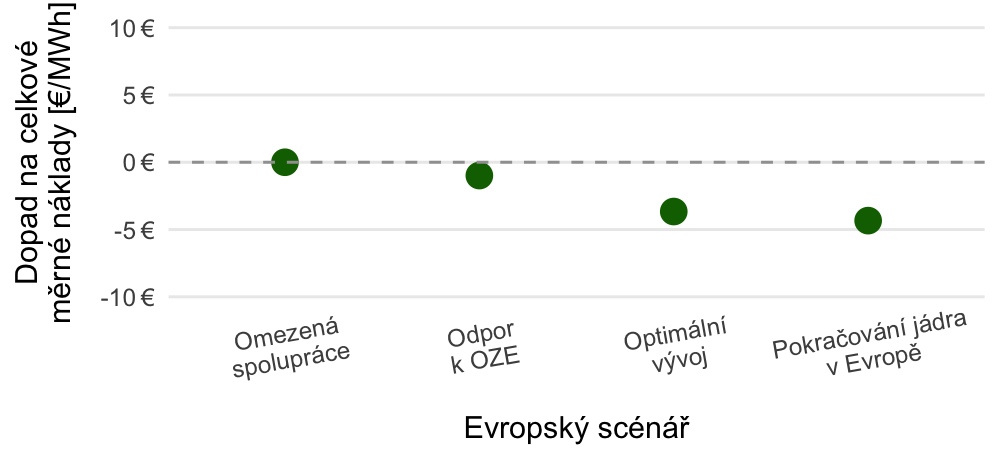

In [20]:
options(repr.plot.width = 5, repr.plot.height = 2.3)

reference_system_costs <- model_system_costs |>
  filter(runset == "core-3yrs-midfine" & context == "Omezená spolupráce" & name == "2")

reference_system_costs <- reference_system_costs |>
  calculate_overrun_scenarios_wacc(
    filter(overrun_params, label == "9405 €/kW"),
    wacc = .04
  ) |>
  mutate(totex_EUR_per_MWh = system_costs_mn_EUR / final_demand_TWh) |>
  mutate(overrun = fct_inorder(overrun))

selected_system_costs <- model_system_costs |>
  filter(runset == "core-3yrs-midfine" & name == "2") |>
  calculate_overrun_scenarios_wacc(
    filter(overrun_params, label == "9405 €/kW"),
    wacc = .04
  ) |>
  mutate(
    totex_EUR_per_MWh = system_costs_mn_EUR / final_demand_TWh,
    totex_increase_EUR_per_MWh = totex_EUR_per_MWh - reference_system_costs$totex_EUR_per_MWh
  ) |>
  mutate(overrun = fct_inorder(overrun))

selected_system_costs |>
  ggplot(aes(context, totex_increase_EUR_per_MWh)) +
  geom_point(
    aes(colour = runset),
    shape = 19,
    size = 4,
    data = selected_system_costs |> filter(overrun == "9405 €/kW"),
  ) +
  scale_x_discrete(
    "Evropský scénář",
    limits = c("Omezená spolupráce", "Odpor k OZE", "Optimální vývoj", "Pokračování jádra v Evropě"),
    labels = c(
      "Omezená spolupráce" = "Omezená\nspolupráce",
      "Optimální vývoj" = "Optimální\nvývoj",
      "Odpor k OZE" = "Odpor\nk OZE",
      "Pokračování jádra v Evropě" = "Pokračování jádra\nv Evropě"
    )
  ) +
  theme(axis.text.x = element_text(angle = 10)) +
  scale_colour_manual(
    values = c(
      "#0d6e00"
    ),
  ) +
  theme(legend.position = "none") +
  geom_hline(yintercept = 0, color = "#a0a0a0", linetype = "dashed") +
  scale_y_continuous(
    "Dopad na celkové\nměrné náklady [€/MWh]",
    labels = scales::label_number(suffix = " €"),
    breaks = seq(-10, 10, 5),
    limits = c(-10, 10),
  )

print(max(selected_system_costs$totex_increase_EUR_per_MWh) - min(selected_system_costs$totex_increase_EUR_per_MWh))

if (save_svgs) {
  ggsave("effect-of-interconnection.svg", width = 5, height = 2.3, create.dir = TRUE)
}


### E. Nuclear

Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“conversion failure on '-10 €' in 'mbcsToSbcs': dot substituted for <e2>”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“conversion failure on '-10 €' in 'mbcsToSbcs': dot substituted for <82>”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“conversion failure on '-10 €' in 'mbcsToSbcs': dot substituted for <ac>”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“conversion failure on '-5 €' in 'mbcsToSbcs': dot substituted for <e2>”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“conversion failure on '-5 €' in 'mbcsToSbcs': dot substituted for <82>”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“conversion failure on '-5 €' in 'mbcsToSbcs': dot substituted for <ac>”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label

[1] 24.28534


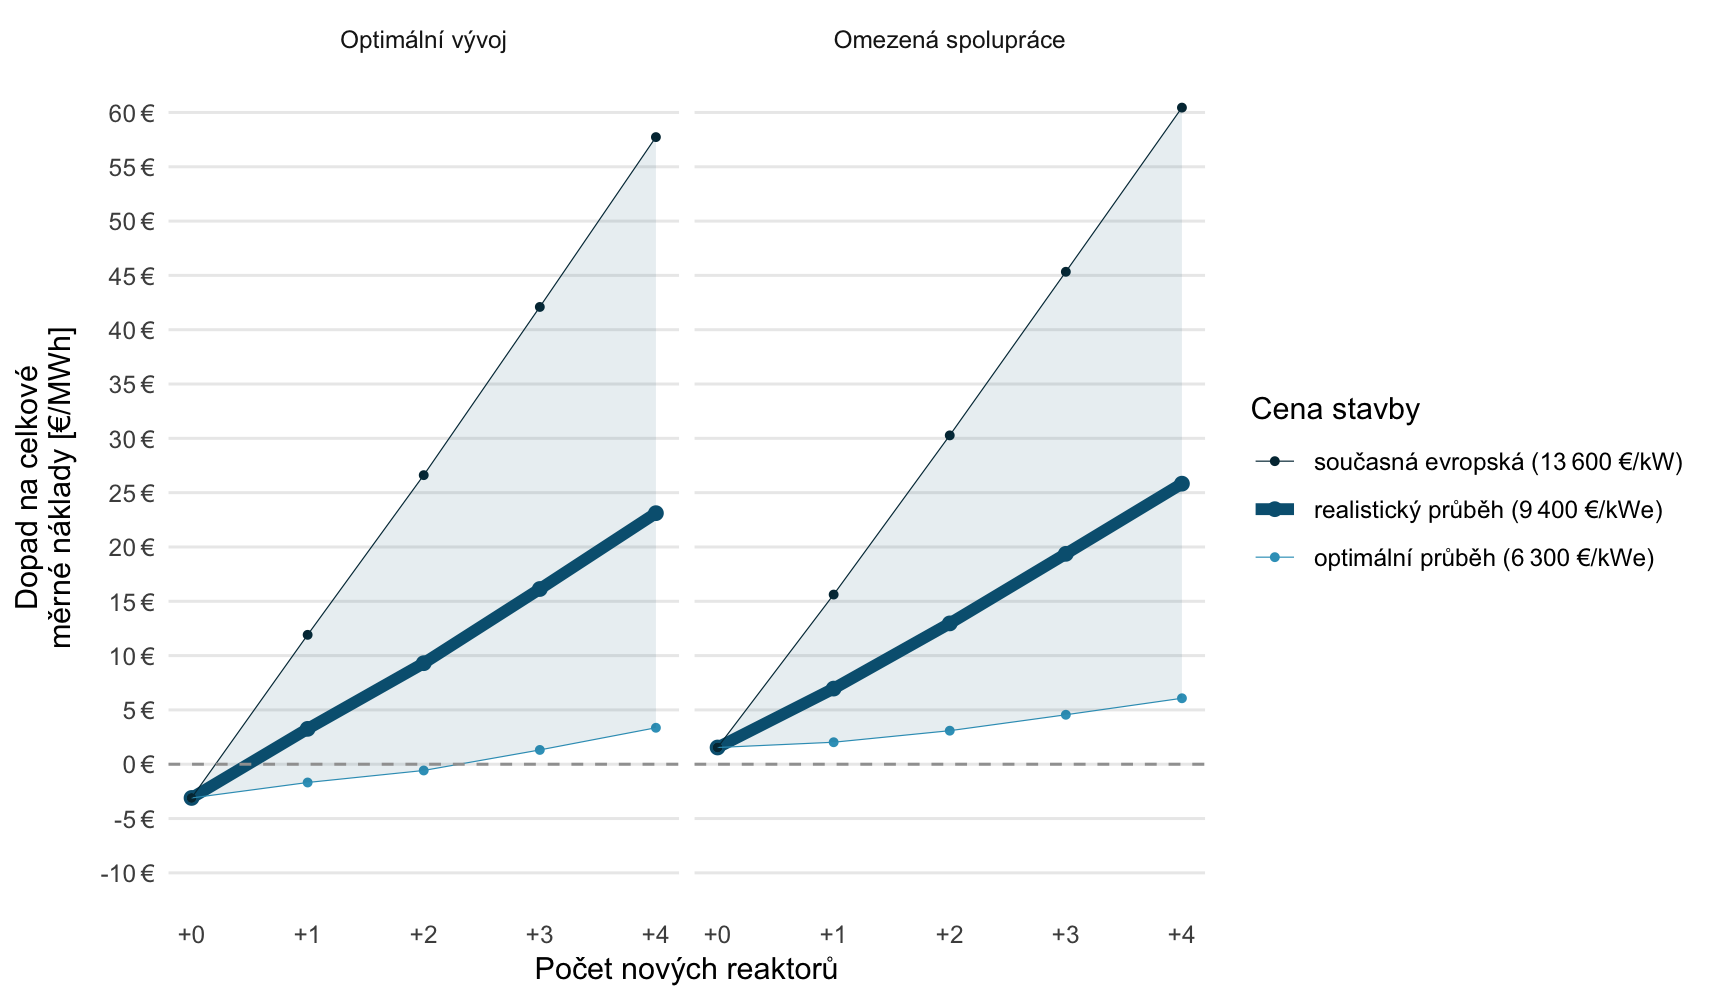

In [21]:
# options(repr.plot.width = 6, repr.plot.height = 2)  # A
# options(repr.plot.width = 8.65, repr.plot.height = 2.6)  # B
options(repr.plot.width = 8.65, repr.plot.height = 5)  # C

reference_system_costs <- model_system_costs |>
  filter(runset == "core-3yrs-midfine" & context == "Omezená spolupráce") |>
  filter(name == "2")

reference_system_costs <- reference_system_costs |>
  calculate_overrun_scenarios_wacc(
    filter(overrun_params, label == "9405 €/kW"),
    wacc = .04
  ) |>
  mutate(totex_EUR_per_MWh = system_costs_mn_EUR / final_demand_TWh) |>
  mutate(overrun = fct_inorder(overrun))

selected_system_costs <- model_system_costs |>
  filter(runset == "core-3yrs-midfine" & (context == "Optimální vývoj" | context == "Omezená spolupráce")) |>
  calculate_overrun_scenarios_wacc(
    # filter(overrun_params, label == "9405 €/kW"),  # A
    filter(overrun_params, label %in% c("6270 €/kW", "9405 €/kW", "13585 €/kW")),  # B+C
    # wacc = .04  # A+B
    wacc = .08  # C
  ) |>
  mutate(
    totex_EUR_per_MWh = system_costs_mn_EUR / final_demand_TWh,
    totex_increase_EUR_per_MWh = totex_EUR_per_MWh - reference_system_costs$totex_EUR_per_MWh
  ) |>
  mutate(overrun = fct_inorder(overrun)) |>
  group_by(context, runset, name) |>
  mutate(
    min_totex_increase_EUR_per_MWh = min(totex_increase_EUR_per_MWh),
    max_totex_increase_EUR_per_MWh = max(totex_increase_EUR_per_MWh)
  ) |>
  ungroup()

selected_system_costs |>
  ggplot(aes(name, totex_increase_EUR_per_MWh)) +
  geom_point(
    aes(colour = overrun),
    shape = 19,
    size = 2,
    data = selected_system_costs |> filter(overrun == "9405 €/kW"),
  ) +
  geom_line(
    aes(colour = overrun, group = overrun),
    linetype = "solid",
    size = 2,
    data = selected_system_costs |> filter(overrun == "9405 €/kW"),
  ) +
  geom_point(
    aes(colour = overrun),
    shape = 19,
    size = 1,
    data = selected_system_costs |> filter(overrun != "9405 €/kW"),
  ) +
  geom_line(
    aes(colour = overrun, group = overrun),
    linetype = "solid",
    size = 0.2,
    data = selected_system_costs |> filter(overrun != "9405 €/kW"),
  ) +
  geom_ribbon(
    aes(ymin = min_totex_increase_EUR_per_MWh, ymax = max_totex_increase_EUR_per_MWh),
    fill = color_nuclear,
    alpha = 0.1
  ) +
  scale_x_continuous(
    "Počet nových reaktorů",
    labels = scales::label_number(prefix = "+")
  ) +
  scale_colour_manual(
    name = "Cena stavby",
    values = c(
      # color_nuclear  # A
      color_nuclear_darker, color_nuclear, color_nuclear_lighter  # B+C
    ),
    # B+C
    breaks=c('13585 €/kW', '9405 €/kW', '6270 €/kW'),
    labels = c("současná evropská (13 600 €/kW)", "realistický průběh (9 400 €/kWe)", "optimální průběh (6 300 €/kWe)"),
  ) +
  facet_grid(cols = vars(context)) +
  # theme(legend.position = "none") +  # A
  geom_hline(yintercept = 0, color = "#a0a0a0", linetype = "dashed") +
  scale_y_continuous(
    "Dopad na celkové\nměrné náklady [€/MWh]",
    labels = scales::label_number(suffix = " €"),
    # A:
    # breaks = seq(-10, 10, 5),
    # limits = c(-10, 10),
    # B:
    # breaks = seq(-10, 20, 5),
    # limits = c(-11, 21),
    # C:
    breaks = seq(-10, 60, 5),
    limits = c(-10, 61),
  )

filtered <- selected_system_costs |> filter(context ==
                                            # "Optimální vývoj"
                                            "Omezená spolupráce"
                                            & overrun ==
                                            # "6270 €/kW"
                                            "9405 €/kW"
                                            # "13585 €/kW"
)

print(max(filtered$totex_increase_EUR_per_MWh) - min(filtered$totex_increase_EUR_per_MWh))

if (save_svgs) {
  # ggsave("effect-of-nuclear-A.svg", width = 6, height = 2, create.dir = TRUE)  # A
  # ggsave("effect-of-nuclear-B.svg", width = 8.65, height = 2.6, create.dir = TRUE)  # B
  ggsave("effect-of-nuclear-C.svg", width = 8.65, height = 5, create.dir = TRUE)  # C
}


### F. SMRs

Warning message:
“Removed 3 rows containing missing values or values outside the scale range
(`geom_point()`).”
Warning message:
“Removed 3 rows containing missing values or values outside the scale range
(`geom_line()`).”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“conversion failure on '5 000 €' in 'mbcsToSbcs': dot substituted for <e2>”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“conversion failure on '5 000 €' in 'mbcsToSbcs': dot substituted for <82>”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“conversion failure on '5 000 €' in 'mbcsToSbcs': dot substituted for <ac>”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“conversion failure on '6 000 €' in 'mbcsToSbcs': dot substituted for <e2>”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“conversion failure on '6 000 €' in 'mbcsToSbcs': dot substitut

[1] 15.27236


Warning message:
“Removed 3 rows containing missing values or values outside the scale range
(`geom_point()`).”
Warning message:
“Removed 3 rows containing missing values or values outside the scale range
(`geom_line()`).”


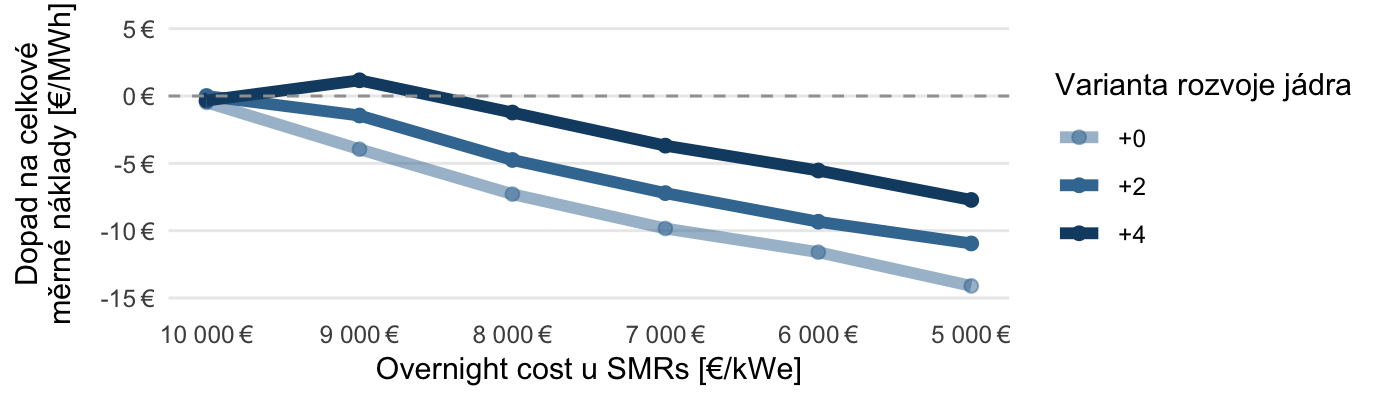

In [22]:
# options(repr.plot.width = 5, repr.plot.height = 2)  # A.
options(repr.plot.width = 6.9, repr.plot.height = 2)  # B.

reference_system_costs <- model_system_costs_effect |>
  filter(runset == "effect-of-smr-2" & context == "Omezená spolupráce") |>
  filter(name == "10000")

reference_system_costs <- reference_system_costs |>
  calculate_overrun_scenarios_wacc(
    filter(overrun_params, label == "9405 €/kW"),
    wacc = .04
  ) |>
  mutate(totex_EUR_per_MWh = system_costs_mn_EUR / final_demand_TWh) |>
  mutate(overrun = fct_inorder(overrun))

selected_system_costs <- model_system_costs_effect |>
  # filter(runset == "effect-of-smr-2" & context == "Omezená spolupráce") |>  # A.
  filter((runset == "effect-of-smr-0" | runset == "effect-of-smr-2" | runset == "effect-of-smr-4") & context == "Omezená spolupráce") |>  # B.
  calculate_overrun_scenarios_wacc(
    filter(overrun_params, label == "9405 €/kW"),
    wacc = .04
  ) |>
  mutate(
    totex_EUR_per_MWh = system_costs_mn_EUR / final_demand_TWh,
    totex_increase_EUR_per_MWh = totex_EUR_per_MWh - reference_system_costs$totex_EUR_per_MWh
  ) |>
  mutate(overrun = fct_inorder(overrun))

selected_system_costs |>
  ggplot(aes(name, totex_increase_EUR_per_MWh)) +
  geom_point(
    aes(color = runset),
    shape = 19,
    size = 2
  ) +
  geom_line(
    aes(group = runset, color = runset),
    size = 2,
  ) +
  scale_x_reverse(
    "Overnight cost u SMRs [€/kWe]",
    labels = scales::label_number(suffix = " €"),
    limits = c(10000, 5000)
  ) +
  scale_colour_manual(
    name = "Varianta rozvoje jádra",
    labels = c("+0", "+2", "+4"),
    values = c(
      # color_smr  # A.
      color_smr_lighter, color_smr, color_smr_darker  # B.
    ),
  ) +
  # theme(legend.position = "none") +  # A.
  geom_hline(yintercept = 0, color = "#a0a0a0", linetype = "dashed") +
  scale_y_continuous(
    "Dopad na celkové\nměrné náklady [€/MWh]",
    labels = scales::label_number(suffix = " €"),
    breaks = seq(-15, 5, 5),
    limits = c(-15, 5),
  )

print(max(selected_system_costs$totex_increase_EUR_per_MWh) - min(selected_system_costs$totex_increase_EUR_per_MWh))

if (save_svgs) {
  # ggsave("effect-of-SMR-A.svg", width = 5, height = 2, create.dir = TRUE)
  ggsave("effect-of-SMR-B.svg", width = 6.9, height = 2, create.dir = TRUE)
}


### Hydrogen

Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“conversion failure on '1,5 €' in 'mbcsToSbcs': dot substituted for <e2>”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“conversion failure on '1,5 €' in 'mbcsToSbcs': dot substituted for <82>”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“conversion failure on '1,5 €' in 'mbcsToSbcs': dot substituted for <ac>”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“conversion failure on '2,0 €' in 'mbcsToSbcs': dot substituted for <e2>”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“conversion failure on '2,0 €' in 'mbcsToSbcs': dot substituted for <82>”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“conversion failure on '2,0 €' in 'mbcsToSbcs': dot substituted for <ac>”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$la

[1] 7.533679


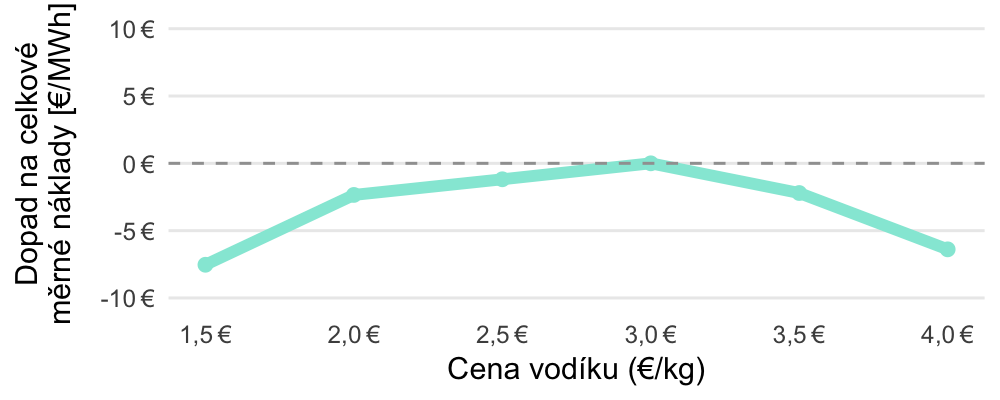

In [23]:
options(repr.plot.width = 5, repr.plot.height = 2)

reference_system_costs <- model_system_costs_effect |>
  filter(runset == "effect-of-hydrogen-price-2" & context == "Omezená spolupráce") |>
  filter(name == "3")

reference_system_costs <- reference_system_costs |>
  calculate_overrun_scenarios_wacc(
    filter(overrun_params, label == "9405 €/kW"),
    wacc = .04
  ) |>
  mutate(totex_EUR_per_MWh = system_costs_mn_EUR / final_demand_TWh) |>
  mutate(overrun = fct_inorder(overrun))

selected_system_costs <- model_system_costs_effect |>
  filter(runset == "effect-of-hydrogen-price-2" & context == "Omezená spolupráce") |>
  calculate_overrun_scenarios_wacc(
    filter(overrun_params, label == "9405 €/kW"),
    wacc = .04
  ) |>
  mutate(
    totex_EUR_per_MWh = system_costs_mn_EUR / final_demand_TWh,
    totex_increase_EUR_per_MWh = totex_EUR_per_MWh - reference_system_costs$totex_EUR_per_MWh
  ) |>
  mutate(overrun = fct_inorder(overrun))

selected_system_costs |>
  ggplot(aes(name, totex_increase_EUR_per_MWh)) +
  geom_point(
    aes(color = runset),
    shape = 19,
    size = 2
  ) +
  geom_line(
    aes(group = runset, color = runset),
    size = 2,
  ) +
  scale_x_continuous(
    "Cena vodíku (€/kg)",
    labels = scales::label_number(suffix=" €", decimal.mark=","),
  ) +
  scale_colour_manual(
    values = c(
      color_hydrogen
    ),
  ) +
  theme(legend.position = "none") +
  geom_hline(yintercept = 0, color = "#a0a0a0", linetype = "dashed") +
  scale_y_continuous(
    "Dopad na celkové\nměrné náklady [€/MWh]",
    labels = scales::label_number(suffix = " €"),
    breaks = seq(-10, 10, 5),
    limits = c(-10, 10),
  )

print(max(selected_system_costs$totex_increase_EUR_per_MWh) - min(selected_system_costs$totex_increase_EUR_per_MWh))

if (save_svgs) {
  ggsave("effect-of-hydrogen.svg", width = 5, height = 2, create.dir = TRUE)
}


## Chart 2b: Costs for nuclear scenarios

Summary of generation from various sources and net imports in each scenario:

Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“conversion failure on '6270 €/kW' in 'mbcsToSbcs': dot substituted for <e2>”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“conversion failure on '6270 €/kW' in 'mbcsToSbcs': dot substituted for <82>”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“conversion failure on '6270 €/kW' in 'mbcsToSbcs': dot substituted for <ac>”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“conversion failure on '9405 €/kW' in 'mbcsToSbcs': dot substituted for <e2>”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“conversion failure on '9405 €/kW' in 'mbcsToSbcs': dot substituted for <82>”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“conversion failure on '9405 €/kW' in 'mbcsToSbcs': dot substituted for <ac>”
Warning message in grid.Call(C_textBound

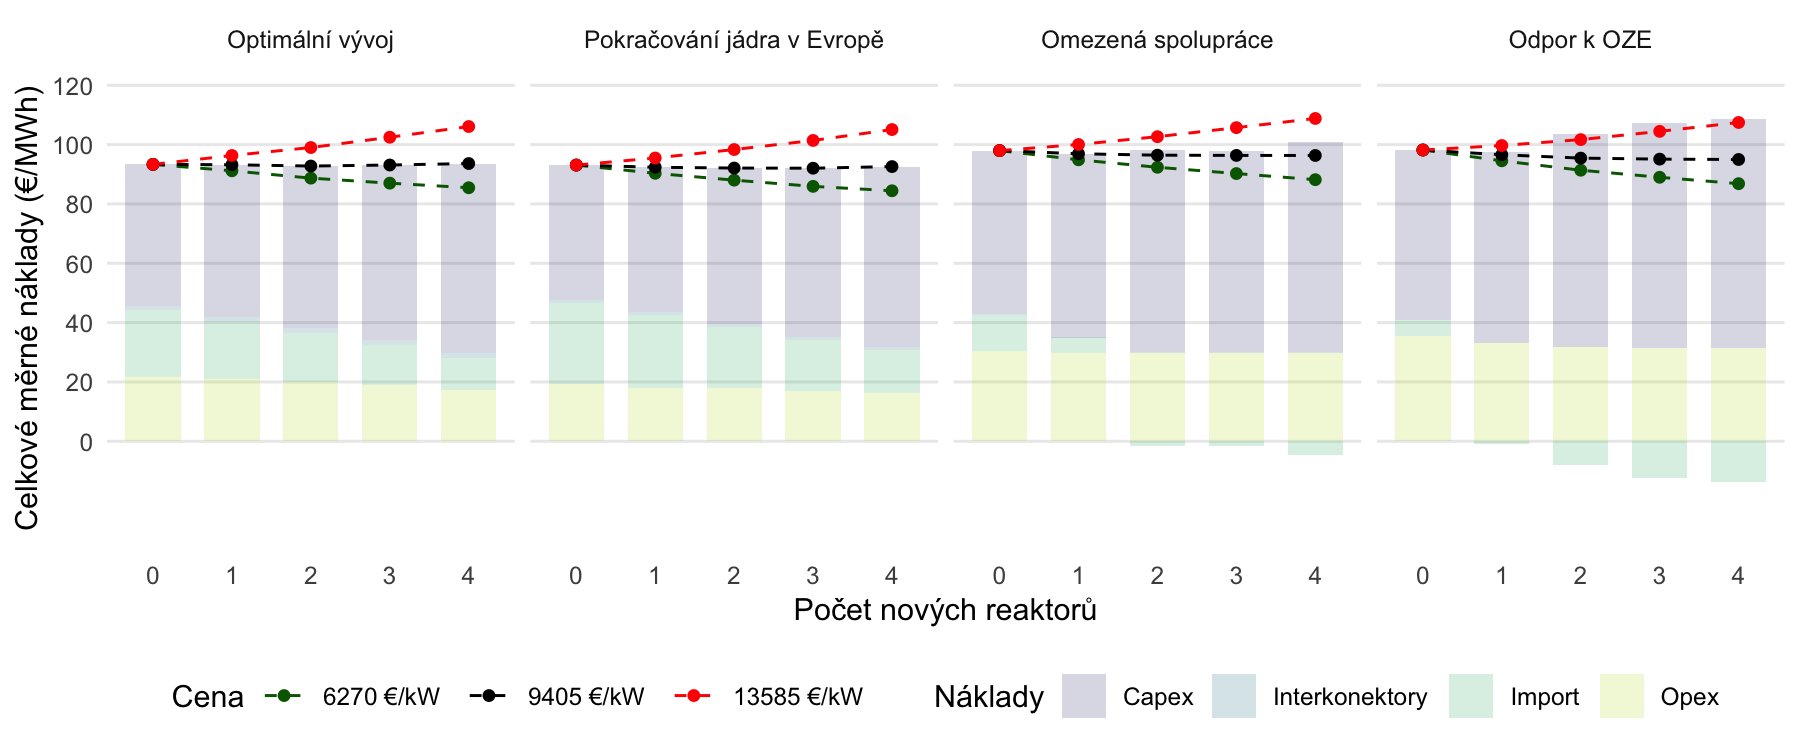

In [24]:
options(repr.plot.width = 9, repr.plot.height = 3.75)

overrun_scenarios <- model_system_costs |>
  filter(runset == "core-3yrs-midfine") |>
  calculate_overrun_scenarios(
    filter(overrun_params, label %in% c("6270 €/kW", "9405 €/kW", "13585 €/kW"))
  ) |>
  # Note that this relies on the factor levels appearing
  # in the correct order in the input.
  mutate(overrun = fct_inorder(overrun))

plot_overruns <- TRUE

p1a <- overrun_scenarios |>
  filter(overrun == "9405 €/kW") |>
  select(
    context:name,
    final_demand_TWh,
    capex_mn_EUR_per_yr,
    opex_mn_EUR,
    interconnector_capex_mn_EUR,
    net_import_costs_mn_EUR
  ) |>
  pivot_longer(!context:final_demand_TWh, names_to = "factor", values_to = "cost_mn_EUR") |>
  ggplot(aes(name, cost_mn_EUR / final_demand_TWh)) +
  geom_col(
    aes(fill = factor),
    width = .7,
    alpha = .2
  ) +
  scale_y_continuous(
    "Celkové měrné náklady (€/MWh)",
    labels = scales::label_number(),
    limits = c(-30, 120),
    breaks = seq(0, 120, 20),
  ) +
  scale_colour_manual(
    "Cena",
    values = c(`9405 €/kW` = "black", `6270 €/kW` = "darkgreen", `13585 €/kW` = "red")
  ) +
  costs_fill_scale() +
  facet_grid(cols = vars(context)) +
  labs(
    x = "Počet nových reaktorů"
  ) +
  theme(legend.position = "bottom")

if (plot_overruns) {
  p1a +
    geom_line(
      aes(y = system_costs_mn_EUR / final_demand_TWh, colour = overrun, group = overrun),
      data = overrun_scenarios,
      linetype = "dashed"
    ) +
    geom_point(
      aes(y = system_costs_mn_EUR / final_demand_TWh, colour = overrun),
      # Don't overplot the black dot in the null scenario.
      data = overrun_scenarios |> filter(overrun == "9405 €/kW" | name != "+0")
    )
} else {
  p1a +
    geom_line(
      aes(y = system_costs_mn_EUR / final_demand_TWh, colour = overrun, group = overrun),
      data = overrun_scenarios |> filter(overrun == "9405 €/kW"),
      linetype = "dashed"
    ) +
    geom_point(
      aes(y = system_costs_mn_EUR / final_demand_TWh, colour = overrun),
      data = overrun_scenarios |> filter(overrun == "9405 €/kW")
    )
}


In [25]:
model_results |>
  filter(
    runset == "core",
    name == "+0",
    (stat == "production_TWh" & (source %in% c("solar", "onshore", "h2", "gas_ccgt_ccs")) |
      (stat == "net_import_TWh"))
  ) |>
  select(context, source, val) |>
  mutate(
    source = if_else(source == "TOTAL", "net import", source)
  ) |>
  pivot_wider(names_from = context, values_from = val) |>
  knitr::kable(digits = 2) |>
  as.character() |>
  IRdisplay::display_html()


source

## Chart 3: Costs increase heatmap


In [26]:
waccs <- seq(.04, .08, .005)

costs_increases <- model_system_costs |>
  filter(runset == "core-3yrs-midfine") |>
  calculate_overrun_scenarios_wacc(overrun_params, waccs) |>
  mutate(totex_EUR_per_MWh = system_costs_mn_EUR / final_demand_TWh) |>
  select(context, name, overrun, wacc, totex_EUR_per_MWh) |>
  pivot_wider(
    names_from = name,
    values_from = totex_EUR_per_MWh
  ) |>
  mutate(
    totex_increase_EUR_per_MWh = (`4` - `0`),
    totex_increase_pct = 100 * (`4` / `0` - 1),
    # Note that this relies on the factor levels appearing
    # in the correct order in the input.
    overrun = fct_inorder(overrun)
  ) |>
  convert_currency(exchange_rate = czk_per_eur)


Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“conversion failure on 'Cena stavby [€/kW]' in 'mbcsToSbcs': dot substituted for <e2>”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“conversion failure on 'Cena stavby [€/kW]' in 'mbcsToSbcs': dot substituted for <82>”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“conversion failure on 'Cena stavby [€/kW]' in 'mbcsToSbcs': dot substituted for <ac>”
Warning message in grid.Call.graphics(C_text, as.graphicsAnnot(x$label), x$x, x$y, :
“conversion failure on 'Cena stavby [€/kW]' in 'mbcsToSbcs': dot substituted for <e2>”
Warning message in grid.Call.graphics(C_text, as.graphicsAnnot(x$label), x$x, x$y, :
“conversion failure on 'Cena stavby [€/kW]' in 'mbcsToSbcs': dot substituted for <82>”
Warning message in grid.Call.graphics(C_text, as.graphicsAnnot(x$label), x$x, x$y, :
“conversion failure on 'Cena stavby [€/kW]' in 'mbcsToSbcs': dot

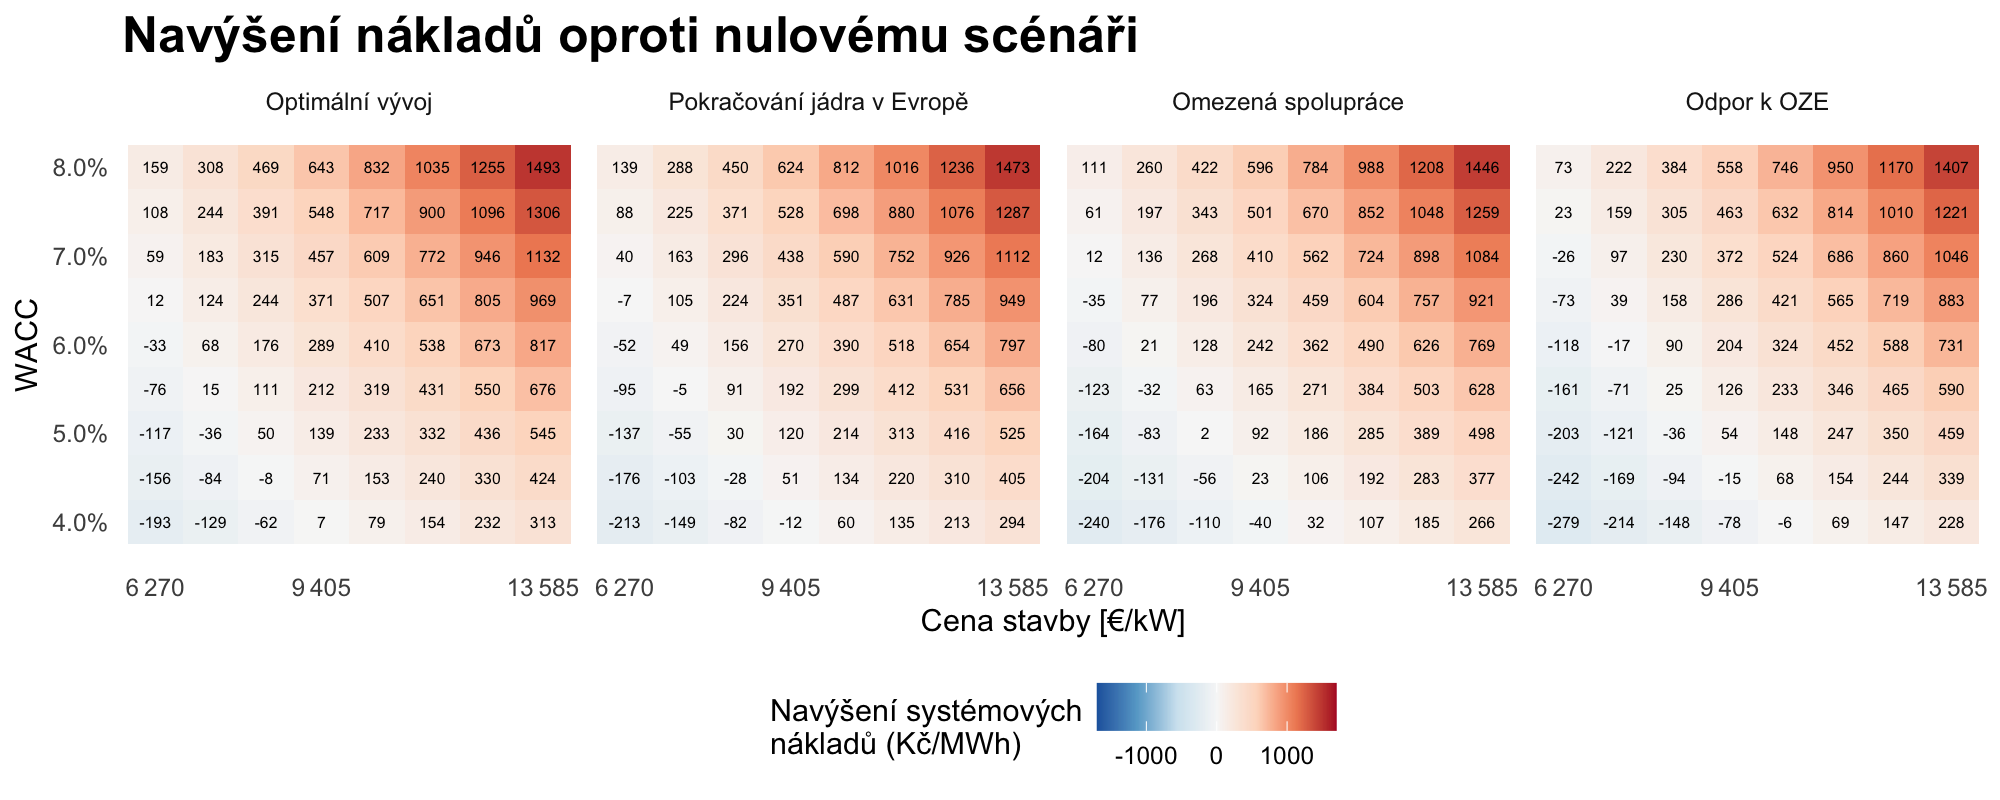

In [27]:
options(repr.plot.width = 10, repr.plot.height = 4)

costs_increases |>
  ggplot(aes(overrun, wacc)) +
  geom_tile(aes(fill = totex_increase_CZK_per_MWh)) +
  geom_text(
    aes(label = round(totex_increase_CZK_per_MWh)),
    size = 2
  ) +
  scale_x_discrete(
    "Cena stavby [€/kW]",
    labels = c("6 270", "", "", "9 405", "", "", "", "13 585")
  ) +
  scale_y_continuous(
    "WACC",
    labels = scales::label_percent()
  ) +
  scale_fill_distiller(
    "Navýšení systémových\nnákladů (Kč/MWh)",
    palette = "RdBu",
    limits = c(-1700, 1700),
  ) +
  facet_grid(cols = vars(context)) +
  labs(
    title = "Navýšení nákladů oproti nulovému scénáři",
    x = "Prodražení stavby"
  ) +
  theme(
    legend.position = "bottom",
    panel.grid.major = element_blank()
  )

if (save_svgs) {
  ggsave("chart-3a-totex-increase-heatmap.svg", width = 10, height = 4, create.dir = TRUE)
}


Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“conversion failure on 'Cena stavby [€/kW]' in 'mbcsToSbcs': dot substituted for <e2>”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“conversion failure on 'Cena stavby [€/kW]' in 'mbcsToSbcs': dot substituted for <82>”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“conversion failure on 'Cena stavby [€/kW]' in 'mbcsToSbcs': dot substituted for <ac>”
Warning message in grid.Call.graphics(C_text, as.graphicsAnnot(x$label), x$x, x$y, :
“conversion failure on 'Cena stavby [€/kW]' in 'mbcsToSbcs': dot substituted for <e2>”
Warning message in grid.Call.graphics(C_text, as.graphicsAnnot(x$label), x$x, x$y, :
“conversion failure on 'Cena stavby [€/kW]' in 'mbcsToSbcs': dot substituted for <82>”
Warning message in grid.Call.graphics(C_text, as.graphicsAnnot(x$label), x$x, x$y, :
“conversion failure on 'Cena stavby [€/kW]' in 'mbcsToSbcs': dot

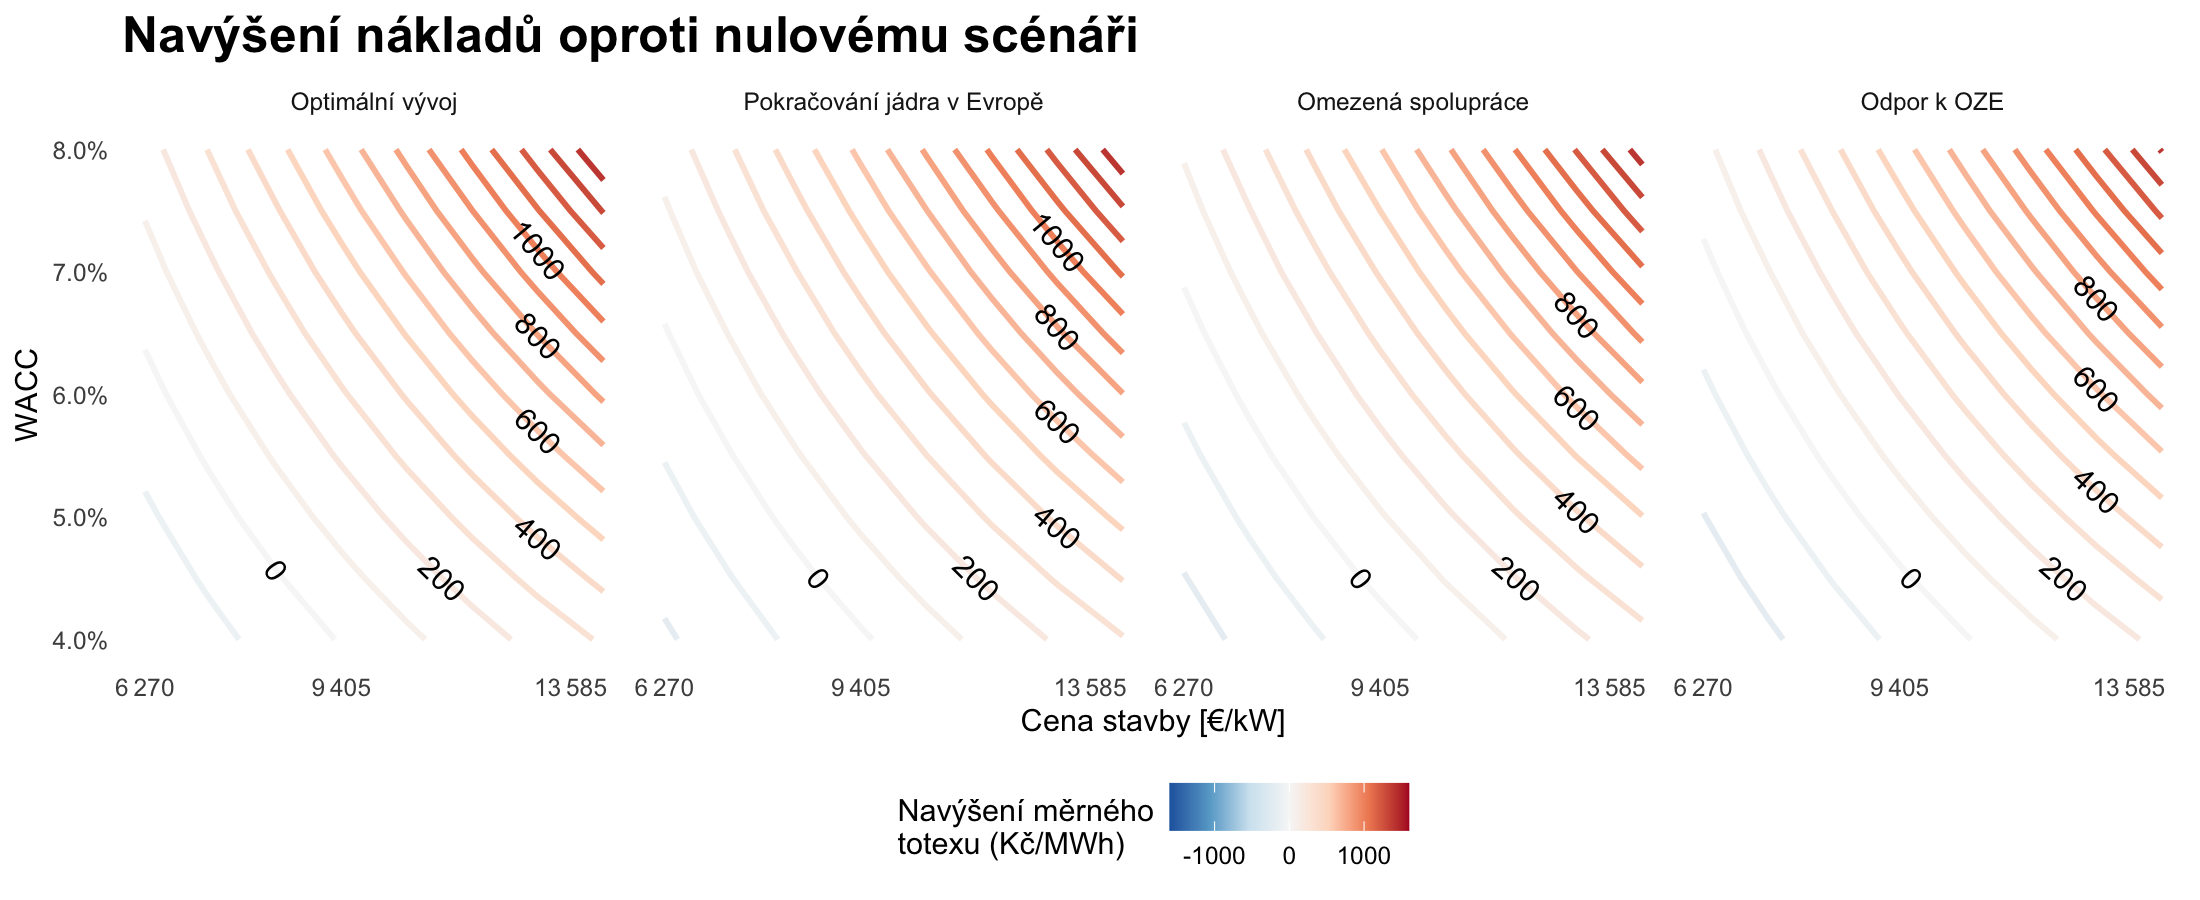

In [28]:
options(repr.plot.width = 11, repr.plot.height = 4.5)

costs_increases |>
  ggplot(aes(as.numeric(overrun), wacc, z = totex_increase_CZK_per_MWh)) +
  geom_contour(
    aes(colour = after_stat(level)),
    linewidth = 1,
    binwidth = 100
  ) +
  metR::geom_text_contour(skip = 0) +
  scale_x_continuous(
    "Cena stavby [€/kW]",
    breaks = c(1, 4, 7.5),
    labels = c("6 270", "9 405", "13 585")
  ) +
  scale_y_continuous(
    "WACC",
    labels = scales::label_percent()
  ) +
  scale_colour_distiller(
    "Navýšení měrného\ntotexu (Kč/MWh)",
    palette = "RdBu",
    limits = c(-1600, 1600)
  ) +
  facet_grid(cols = vars(context)) +
  ggtitle("Navýšení nákladů oproti nulovému scénáři") +
  theme(
    legend.position = "bottom",
    panel.grid.major = element_blank()
  )

if (save_svgs) {
  ggsave("chart-3b-totex-increase-contour.svg", width = 11, height = 4.5, create.dir = TRUE)
}


Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“conversion failure on 'Cena stavby [€/kW]' in 'mbcsToSbcs': dot substituted for <e2>”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“conversion failure on 'Cena stavby [€/kW]' in 'mbcsToSbcs': dot substituted for <82>”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“conversion failure on 'Cena stavby [€/kW]' in 'mbcsToSbcs': dot substituted for <ac>”
Warning message in grid.Call.graphics(C_text, as.graphicsAnnot(x$label), x$x, x$y, :
“conversion failure on 'Cena stavby [€/kW]' in 'mbcsToSbcs': dot substituted for <e2>”
Warning message in grid.Call.graphics(C_text, as.graphicsAnnot(x$label), x$x, x$y, :
“conversion failure on 'Cena stavby [€/kW]' in 'mbcsToSbcs': dot substituted for <82>”
Warning message in grid.Call.graphics(C_text, as.graphicsAnnot(x$label), x$x, x$y, :
“conversion failure on 'Cena stavby [€/kW]' in 'mbcsToSbcs': dot

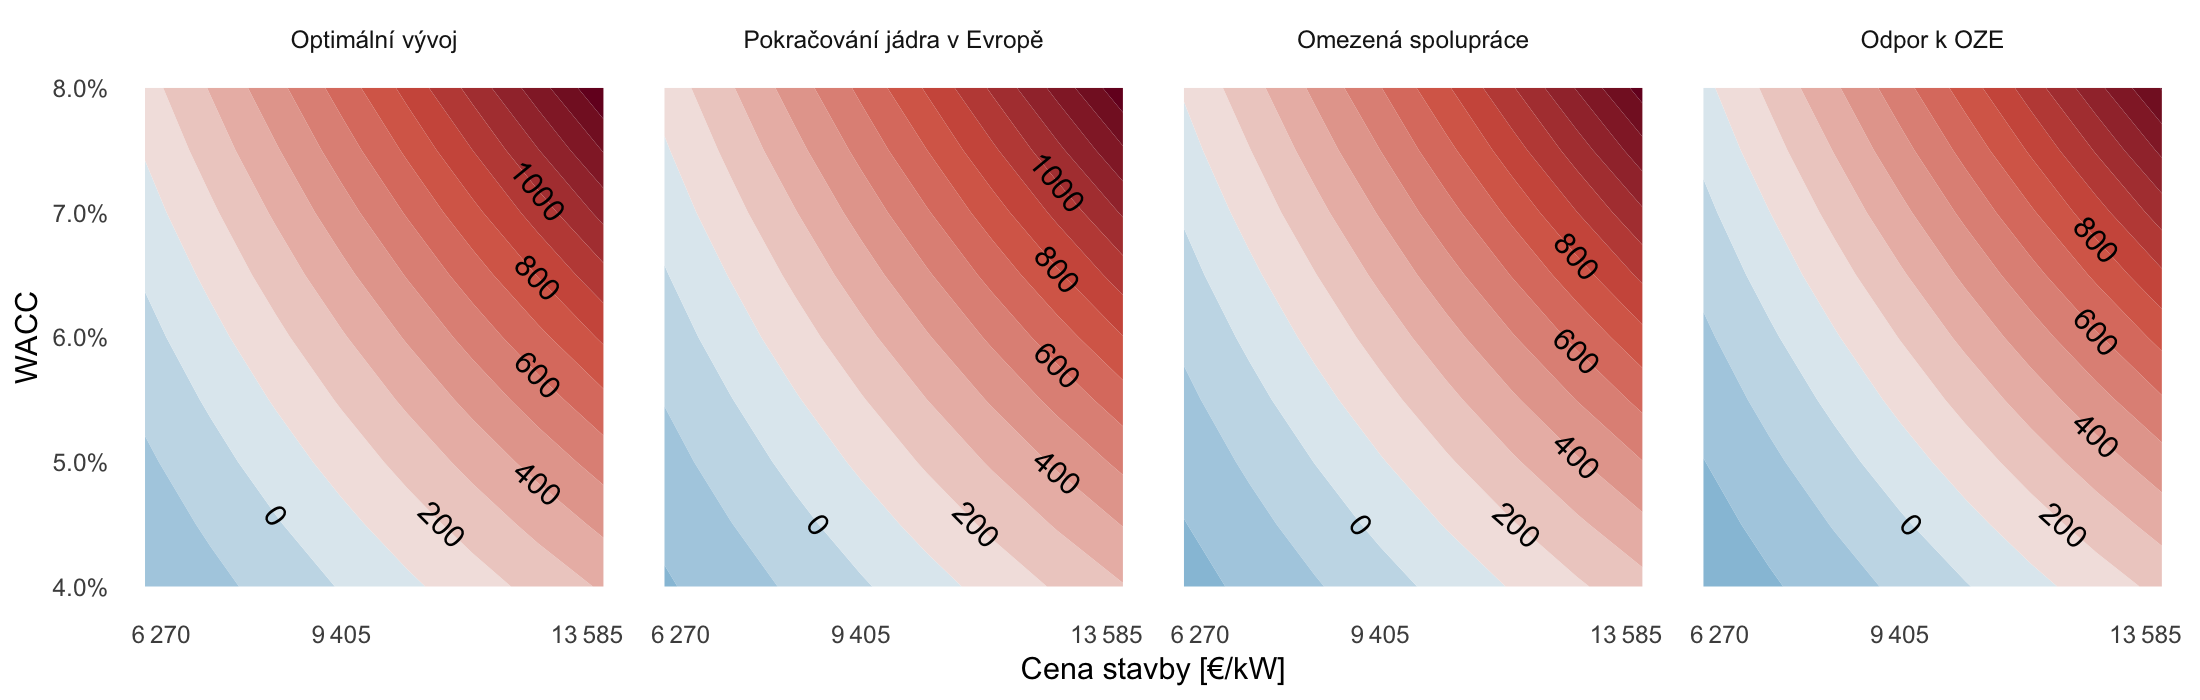

In [29]:
options(repr.plot.width = 11, repr.plot.height = 3.5)

costs_increases |>
  ggplot(aes(as.numeric(overrun), wacc, z = totex_increase_CZK_per_MWh)) +
  metR::geom_contour_fill(
    aes(fill = after_stat(level)),
    breaks = seq(-600, 1700, 100),
  ) +
  metR::geom_text_contour(skip = 0) +
  scale_x_continuous(
    "Cena stavby [€/kW]",
    breaks = c(1.25, 4, 7.75),
    labels = c("6 270", "9 405", "13 585"),
  ) +
  scale_y_continuous(
    "WACC",
    labels = scales::label_percent()
  ) +
  scale_fill_manual(
    "Navýšení měrného\ntotexu (Kč/MWh)",
    values = c(
      # '#67a7cd', '#7fb4d4',
      '#97c2db', '#afcfe2', '#c7dce9', '#dfeaf0', '#f3e3e0', '#eecfca', '#eabbb3', '#e5a69c', '#e19286', '#dd7e6f', '#d86a58', '#cf5a4a', '#c04d44', '#b1403e', '#a23338', '#932631', '#851a2b', '#760d25', '#67001f', '#57001a', '#490016', '#2d000d'),
    # breaks = seq(-1500, 1500, 100),
    guide = "none"
  ) +
  facet_grid(cols = vars(context)) +
  theme(
    legend.position = "bottom",
    panel.grid.major = element_blank()
  )

if (save_svgs) {
  ggsave("chart-3c-totex-increase-contour-filled.svg", width = 11, height = 3.5, create.dir = TRUE)
}


## Chart 4: Sensitivity analyses summary bars


In [30]:
reference_costs_3yrs <- model_system_costs |>
  filter(runset == "core-3yrs-midfine") |>
  calculate_overrun_scenarios_wacc(
    filter(overrun_params, label == "9405 €/kW"),
    wacc = .04
  ) |>
  mutate(
    totex_EUR_per_MWh = system_costs_mn_EUR / final_demand_TWh,
    totex_increase_EUR_per_MWh_3yrs = totex_EUR_per_MWh - totex_EUR_per_MWh[name == "2" & context == "Omezená spolupráce"],
  )

reference_costs <- model_system_costs |>
  filter(runset == "core") |>
  calculate_overrun_scenarios_wacc(
    filter(overrun_params, label == "9405 €/kW"),
    wacc = .04
  ) |>
  mutate(
    totex_EUR_per_MWh = system_costs_mn_EUR / final_demand_TWh,
    totex_increase_EUR_per_MWh = totex_EUR_per_MWh - totex_EUR_per_MWh[name == "2" & context == "Omezená spolupráce"],
  )

diff <- left_join(reference_costs_3yrs, reference_costs, join_by(context, name)) |>
  mutate(diff_of_increase = totex_increase_EUR_per_MWh_3yrs - totex_increase_EUR_per_MWh) |>
  select(context, name, diff_of_increase)

scenarios_labels <- c(
  "sceptic-demand" = "Vysoká spotřeba\n(+20 %)",
  "optimistic-demand" = "Nízká spotřeba\n(-20 %)",
  "sceptic-wind" = "Málo větru\n(3 GW)",
  "optimistic-wind" = "Více větru\n(12 GW)",
  "sceptic-prices" = "Vyšší ceny OZE",
  "optimistic-prices" = "Nižší ceny OZE",
  "sceptic-demand+ccs+smr" = "Kritická sada\n(vysoká spotřeba\nbez SMR a CCUS)",
  "optimistic-smr" = "Levné SMRs\n(7000 €/kWe)",
  "core-3yrs-midfine" = "Referenční sada"
)


Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“conversion failure on '-20 €' in 'mbcsToSbcs': dot substituted for <e2>”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“conversion failure on '-20 €' in 'mbcsToSbcs': dot substituted for <82>”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“conversion failure on '-20 €' in 'mbcsToSbcs': dot substituted for <ac>”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“conversion failure on '-15 €' in 'mbcsToSbcs': dot substituted for <e2>”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“conversion failure on '-15 €' in 'mbcsToSbcs': dot substituted for <82>”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“conversion failure on '-15 €' in 'mbcsToSbcs': dot substituted for <ac>”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$la

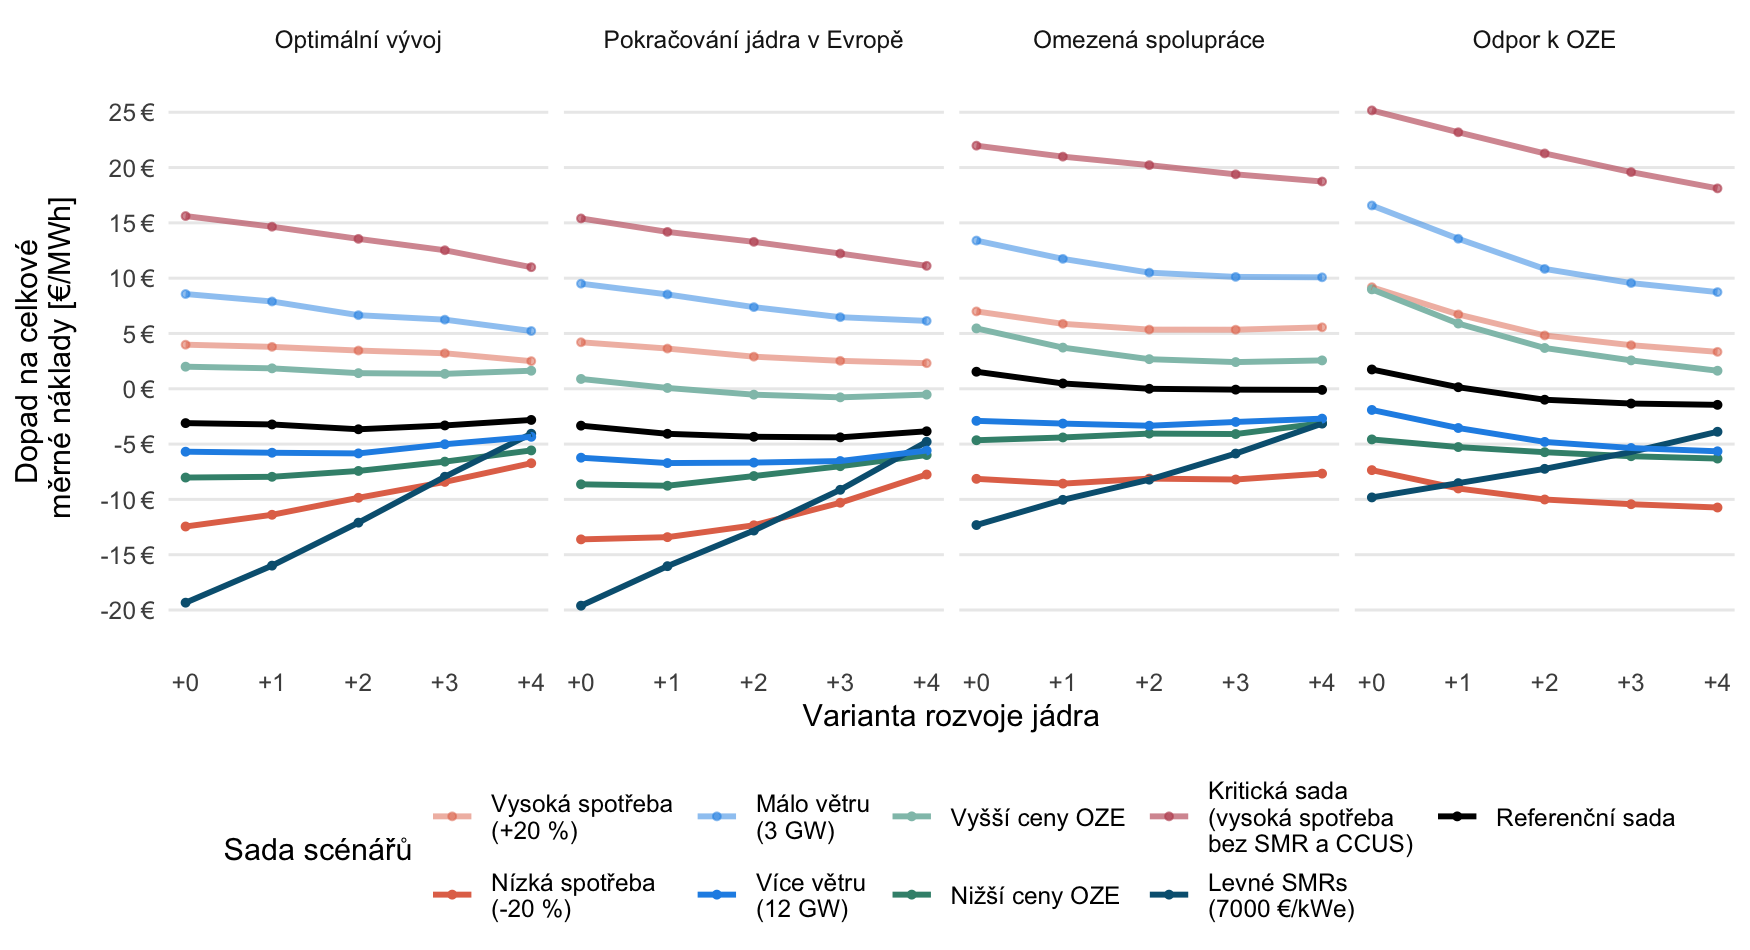

In [31]:
options(repr.plot.width = 8.75, repr.plot.height = 4.75)

normalized_system_costs <- model_system_costs |>
  left_join(diff, join_by(context, name)) |>
  calculate_overrun_scenarios_wacc(
    filter(overrun_params, label == "9405 €/kW"),
    wacc = .04
  ) |>
  # Diff to reference scenario
  mutate(
    totex_EUR_per_MWh = system_costs_mn_EUR / final_demand_TWh,
    totex_increase_EUR_per_MWh = ifelse(runset == "core-3yrs-midfine",
      reference_costs_3yrs$totex_increase_EUR_per_MWh_3yrs,
      totex_EUR_per_MWh - totex_EUR_per_MWh[runset == "core" & name == "2" & context == "Omezená spolupráce"] + diff_of_increase
    )
  ) |>
  filter(runset != "core")

write.table(normalized_system_costs, file = "plot25.csv", sep=",", row.names=FALSE)

normalized_system_costs |>
  ggplot(aes(name, totex_increase_EUR_per_MWh)) +
  geom_point(
    aes(colour = runset),
    shape = 19,
    size = 1
  ) +
  geom_line(
    aes(colour = runset, group = runset),
    linetype = "solid",
    size = 1,
  ) +
  scale_y_continuous(
    "Dopad na celkové\n měrné náklady [€/MWh]",
    labels = scales::label_number(suffix = " €"),
    breaks = seq(-20, 25, 5),
    limits = c(-22, 27),
  ) +
  scale_colour_manual(
    "Sada scénářů",
    values = c(
      color_demand_alpha, color_demand,
      color_wind_alpha, color_wind,
      color_prices_alpha, color_prices,
      color_critical, color_nuclear,
      "#000000"
    ),
    limits = c(
      "sceptic-demand", "optimistic-demand",
      "sceptic-wind", "optimistic-wind",
      "sceptic-prices", "optimistic-prices",
      "sceptic-demand+ccs+smr", "optimistic-smr",
      "core-3yrs-midfine"
    ),
    labels = scenarios_labels
  ) +
  facet_grid(cols = vars(context)) +
  scale_x_continuous(
    "Varianta rozvoje jádra",
    labels = scales::label_number(prefix = "+")
  ) +
  theme(legend.position = "bottom")

if (save_svgs) {
  ggsave("nuclear-1-all.svg", width = 8.75, height = 4.75, create.dir = TRUE)
}


Warning message:
“Removed 2 rows containing missing values or values outside the scale range
(`geom_point()`).”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“conversion failure on '0 €' in 'mbcsToSbcs': dot substituted for <e2>”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“conversion failure on '0 €' in 'mbcsToSbcs': dot substituted for <82>”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“conversion failure on '0 €' in 'mbcsToSbcs': dot substituted for <ac>”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“conversion failure on '5 €' in 'mbcsToSbcs': dot substituted for <e2>”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“conversion failure on '5 €' in 'mbcsToSbcs': dot substituted for <82>”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“conversion failure on '5 €' in 'mbc

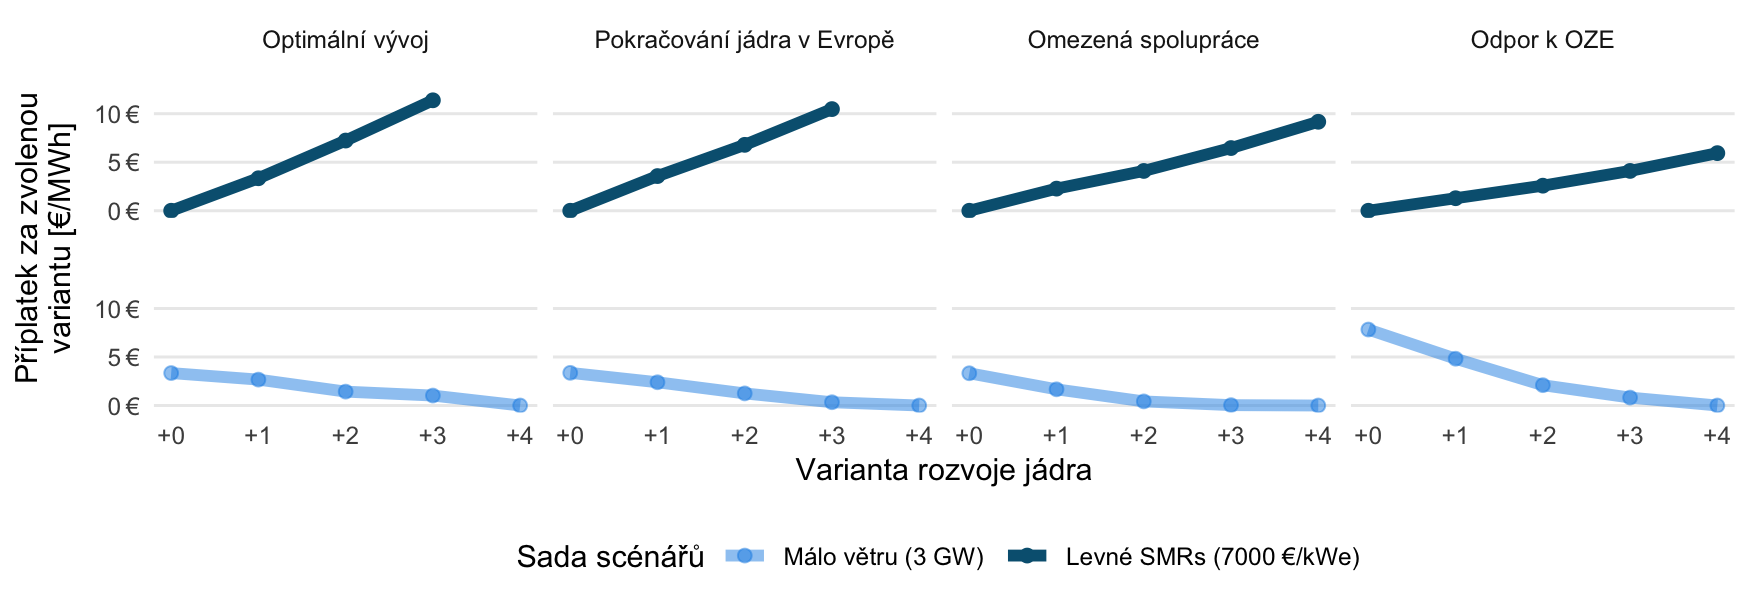

In [32]:
options(repr.plot.width = 8.75, repr.plot.height = 3.05)

model_system_costs |>
  left_join(diff, join_by(context, name)) |>
  calculate_overrun_scenarios_wacc(
    filter(overrun_params, label == "9405 €/kW"),
    wacc = .04
  ) |>
  group_by(context, runset, overrun) |>
  mutate(
    totex_EUR_per_MWh = system_costs_mn_EUR / final_demand_TWh,
    totex_increase_EUR_per_MWh = totex_EUR_per_MWh - min(totex_EUR_per_MWh) + diff_of_increase,
    totex_increase_EUR_per_MWh = totex_increase_EUR_per_MWh - min(totex_increase_EUR_per_MWh),
  ) |>
  ungroup() |>

  # Individual variants
  filter(
    runset == "sceptic-wind" |
    runset == "optimistic-smr") |>

  ggplot(aes(name, totex_increase_EUR_per_MWh)) +
  geom_point(
    aes(colour = runset),
    data = ~ filter(.x),
    size = 2,
  ) +
  geom_line(
    aes(colour = runset, group = runset),
    linetype = "solid",
    size = 2,
  ) +
  scale_y_continuous(
    "Příplatek za zvolenou\nvariantu [€/MWh]",
    labels = scales::label_number(suffix = " €"),
    breaks = seq(0, 10, 5),
    limits = c(0, 14.5),
  ) +
scale_colour_manual(
    "Sada scénářů",
    values = c(
      color_wind_alpha,
      color_nuclear
    ),
    limits = c(
      "sceptic-wind",
      "optimistic-smr"
    ),
    labels = c(
      "sceptic-wind" = "Málo větru (3 GW)",
      "optimistic-smr" = "Levné SMRs (7000 €/kWe)"
    ),
  ) +
  facet_grid(cols = vars(context), rows = vars(runset)) +
  scale_x_continuous(
    "Varianta rozvoje jádra",
    labels = scales::label_number(prefix = "+")
  ) +
  theme(
    legend.position = "bottom",
    panel.spacing.y = unit(1, "lines"),
    strip.text.y = element_blank()
  )

if (save_svgs) {
  ggsave("nuclear-2-selected.svg", width = 8.75, height = 3.05, create.dir = TRUE)
}


## Chart 5: Sensitivity analyses scatter (“butterfly chart”)


Warning message:
“Removed 2 rows containing non-finite outside the scale range
(`stat_summary()`).”
Warning message:
“Removed 2 rows containing non-finite outside the scale range
(`stat_summary()`).”
Warning message:
“Removed 2 rows containing missing values or values outside the scale range
(`position_quasirandom()`).”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“conversion failure on '0 €' in 'mbcsToSbcs': dot substituted for <e2>”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“conversion failure on '0 €' in 'mbcsToSbcs': dot substituted for <82>”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“conversion failure on '0 €' in 'mbcsToSbcs': dot substituted for <ac>”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“conversion failure on '5 €' in 'mbcsToSbcs': dot substituted for <e2>”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$

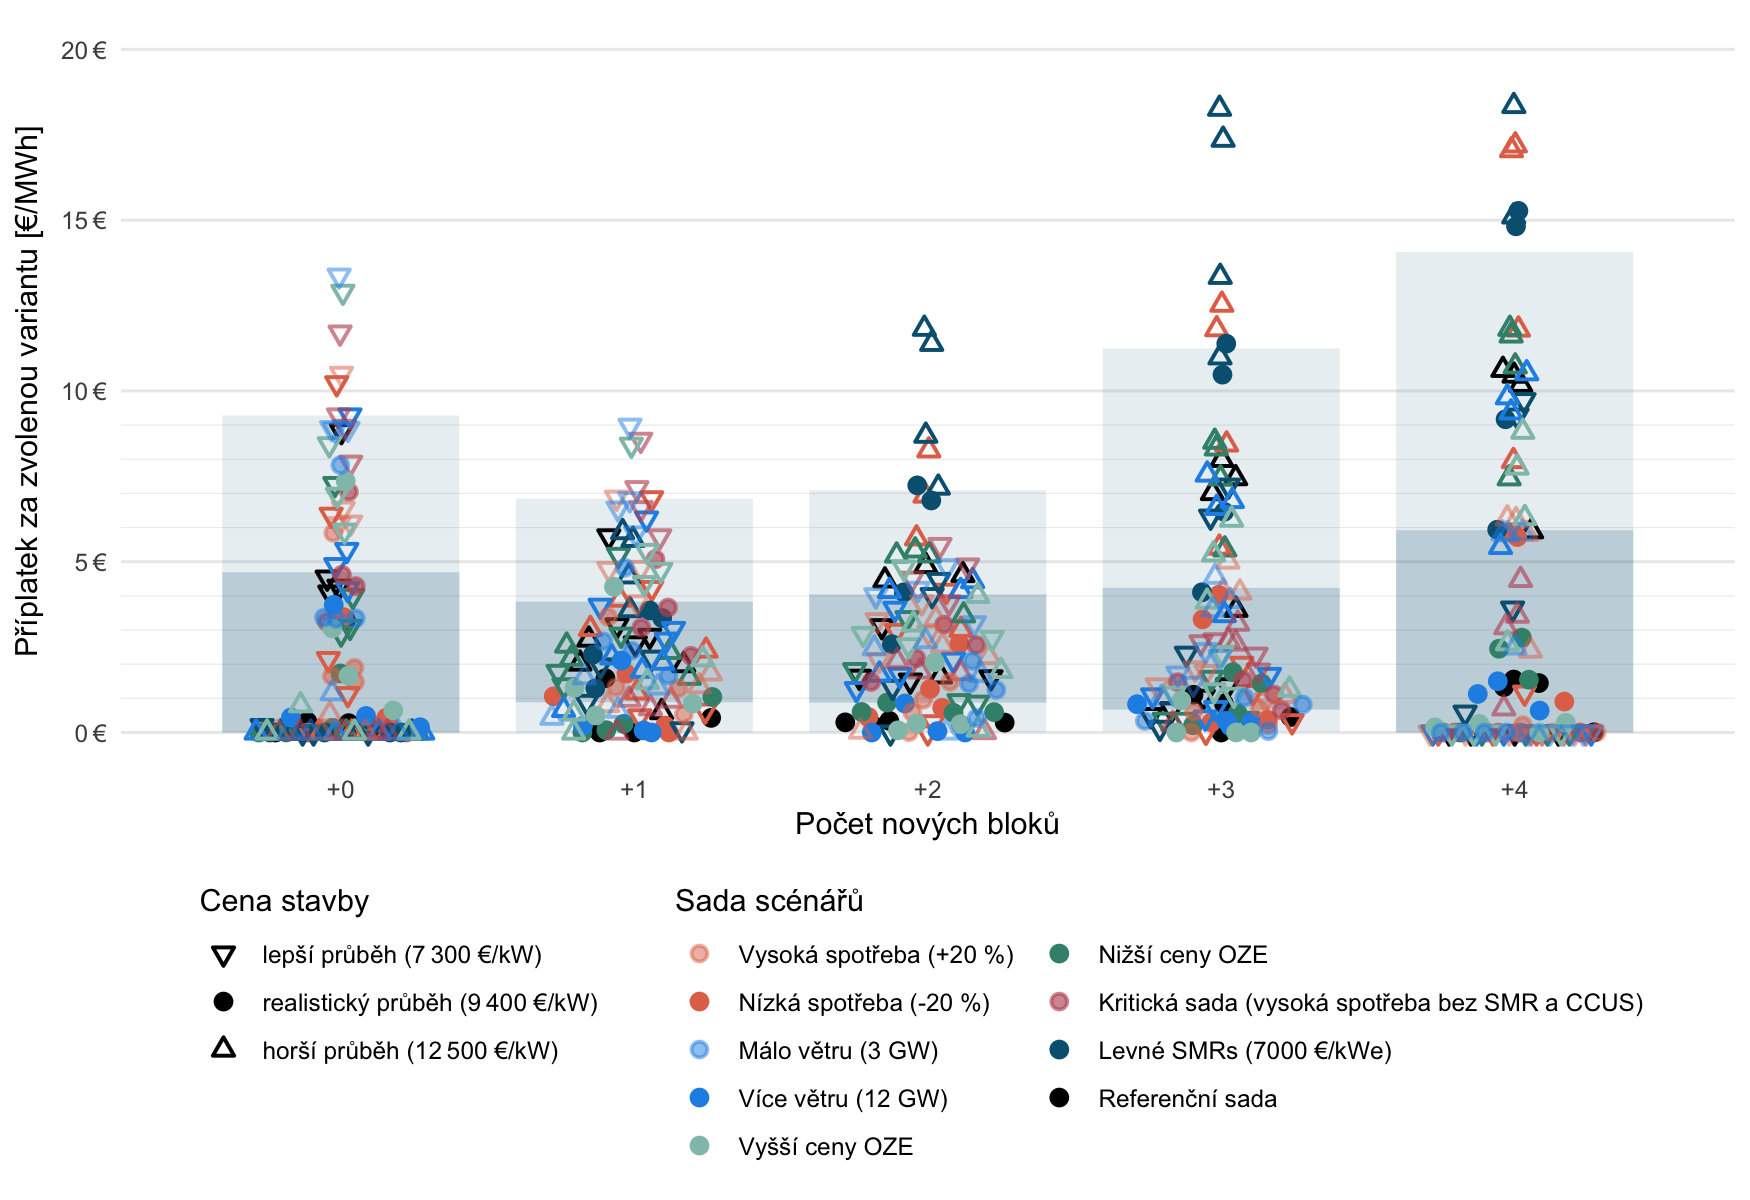

In [39]:
options(repr.plot.width = 8.75, repr.plot.height = 6)  # A. Detailed graphs
# options(repr.plot.width = 8.75, repr.plot.height = 3.78)  # A3. Detailed graphs for slides
# options(repr.plot.width = 6, repr.plot.height = 4)  # B. Exec summary

quartiles <- function(x) {
  r <- quantile(x, probs = c(0.25, 0.75))
  names(r) <- c("ymin", "ymax")
  return(r)
}
range <- function(x) {
  r <- quantile(x, probs = c(0.05, 0.95))
  names(r) <- c("ymin", "ymax")
  return(r)
}

overrun_scenarios_butterfly <- model_system_costs |>
  filter(runset != "core") |>
  left_join(diff, join_by(context, name)) |>
  calculate_overrun_scenarios_wacc(
    filter(overrun_params, label %in% c("6270 €/kW", "7315 €/kW", "8360 €/kW", "9405 €/kW", "10450 €/kW", "11495 €/kW", "12540 €/kW", "13585 €/kW")),
    wacc = .04
  ) |>
  # Previous normalization to min of a runset.
  group_by(context, runset, overrun) |>
  mutate(
    totex_EUR_per_MWh = system_costs_mn_EUR / final_demand_TWh,
    totex_increase_EUR_per_MWh = totex_EUR_per_MWh - min(totex_EUR_per_MWh) + diff_of_increase,
    totex_increase_EUR_per_MWh = totex_increase_EUR_per_MWh - min(totex_increase_EUR_per_MWh),
  ) |>
  ungroup() |>
  mutate(overrun = fct_inorder(overrun))

write.table(overrun_scenarios_butterfly, file = "plot27.csv", sep=",", row.names=FALSE)

overrun_scenarios_butterfly |>
  filter(
    overrun %in% c("7315 €/kW", "9405 €/kW", "12540 €/kW")
  ) |>
  ggplot(aes(name, totex_increase_EUR_per_MWh)) +
  stat_summary(fun.data = range,
               geom = "linerange",
               position = position_dodge(width = 1),
               color = color_nuclear,
               # A. detailed graphs
              #  alpha = 0,  # A2. for slides
               alpha = 0.1,
               size = 40,
               # B. exec summary
              #  alpha = 0.2,
              #  size = 15,

               aes(group = name)) +
  stat_summary(fun.data = quartiles,
               geom = "linerange",
               position = position_dodge(width = 1),
               color = color_nuclear,
               # A. detailed graphs
              #  alpha = 0,  # A2. for slides
               alpha = 0.2,
               size = 40,
               # B. exec summary
              #  alpha = 0.8,
              #  size = 15,

               aes(group = name)) +

  geom_quasirandom(  # A. detailed graphs
    aes(colour = runset, shape = overrun),
    size = 2,
    stroke = 1,
    width = .3
  ) +

  scale_y_continuous(
    labels = scales::label_number(suffix = " €"),
    # A. Detailed graphs
    "Příplatek za zvolenou variantu [€/MWh]",  # A. detailed graphs
    breaks = seq(0, 20, 5),
    limits = c(0, 20),
    minor_breaks = seq(0, 10, 1),
    # B. Exec summary
    # "Prodražení celkových nákladů [€/MWh]",  # B. exec summary
    # breaks = seq(0, 15, 5),
    # limits = c(0, 15),
  ) +
  scale_shape_manual(
    "Cena stavby",
    values = c(25, 19, 24),
    labels = c(
      "7315 €/kW" = "lepší průběh (7 300 €/kW)",
      "9405 €/kW" = "realistický průběh (9 400 €/kW)",
      "12540 €/kW" = "horší průběh (12 500 €/kW)"
    ),
  ) +
  guides(color = guide_legend(ncol = 2)) +
  scale_colour_manual(
    "Sada scénářů",
    values = c(
      color_demand_alpha, color_demand,
      color_wind_alpha, color_wind,
      color_prices_alpha, color_prices,
      color_critical, color_nuclear,
      "#000000"
    ),
    limits = c(
      "sceptic-demand", "optimistic-demand",
      "sceptic-wind", "optimistic-wind",
      "sceptic-prices", "optimistic-prices",
      "sceptic-demand+ccs+smr", "optimistic-smr",
      "core-3yrs-midfine"
    ),
    labels = str_replace_all(scenarios_labels, "\n", " ")
  ) +
  scale_x_continuous(
    # "Varianta rozvoje jádra",  # A. detailed graphs
    "Počet nových bloků",  # B. exec summary
    labels = scales::label_number(prefix = "+")
  ) +
  theme(
    legend.direction = "vertical",
    legend.position = "bottom",
    panel.grid.minor.y = element_line(colour="#eeeeee", size=0.2)  # A. Detailed graph
  )

if (save_svgs) {
  ggsave("nuclear-3-butterfly-detailed.svg", width = 8.75, height = 6, create.dir = TRUE)  # A
  # ggsave("nuclear-4-butterfly-simple.svg", width = 8.75, height = 4, create.dir = TRUE)  # B
}


## Dashboard

In [34]:
selection <- model_results |>
  filter(name == "4" & runset == "core-3yrs-midfine" & context == "Odpor k OZE")
dashboard <- selection |>
  filter(source != "TOTAL") |>
  filter(stat == "production_TWh" | stat == "charged_TWh" | stat == "capacity_GW" | stat == "capacity_charging_GW") |>
  select(c(source, val, stat))

dashboard_expenses <- selection |>
  filter(source != "TOTAL") |>
  filter(stat == "capex_mn_EUR_per_yr" | stat == "opex_mn_EUR") |>
  select(c(source, val, stat)) |>
  pivot_wider(names_from = stat, values_from = val) |>
  mutate(
    totex_bil_CZK = (capex_mn_EUR_per_yr + opex_mn_EUR) * czk_per_eur / 1000,
    stat = "totex_bil_CZK"
  ) |>
  select(source, totex_bil_CZK, stat)
names(dashboard_expenses)[names(dashboard_expenses) == 'totex_bil_CZK'] <- 'val'
dashboard <- rbind(dashboard, dashboard_expenses)

dashboard_cap <- dashboard |> filter(stat == "capacity_GW" | stat == "capacity_charging_GW")
dashboard <- rbind(dashboard, data.frame(
  source = c("hydro", "pumped", "hydrogen", "electrolysis", "short"),
  val = c(
    with(dashboard_cap, sum(val[(source == "h_dams" | source == "h_ror") & stat == "capacity_GW"])),
    with(dashboard_cap, sum(val[(source == "pump" | source == "pump_open") & stat == "capacity_GW"])),
    with(dashboard_cap, sum(val[((source == "h2" | source == "h2p") & stat == "capacity_GW")])),
    with(dashboard_cap, sum(val[((source == "h2" | source == "h2p") & stat == "capacity_charging_GW")])),
    with(dashboard_cap, sum(val[((source == "pump" | source == "pump_open" | source == "li-2" | source == "v2g") & stat == "capacity_GW")]))
  ),
  stat = c("capacity_GW"),
  stringsAsFactors = FALSE
))

dashboard_prod <- dashboard |> filter(stat == "production_TWh")
dashboard <- rbind(dashboard, data.frame(
  source = c("hydro", "pumped", "hydrogen", "short"),
  val = c(
    with(dashboard_prod, sum(val[(source == "h_dams" | source == "h_ror")])),
    with(dashboard_prod, sum(val[(source == "pump" | source == "pump_open")])),
    with(dashboard_prod, sum(val[(source == "h2" | source == "h2p")])),
    with(dashboard_prod, sum(val[(source == "pump" | source == "pump_open" | source == "li-2" | source == "v2g")]))
  ),
  stat = c("production_TWh"),
  stringsAsFactors = FALSE
))

dashboard_charg <- dashboard |> filter(stat == "charged_TWh")
dashboard <- rbind(dashboard, data.frame(
  source = c("pumped", "hydrogen"),
  val = c(
    with(dashboard_charg, sum(val[(source == "pump" | source == "pump_open")])),
    with(dashboard_charg, sum(val[(source == "h2" | source == "h2p")]))
  ),
  stat = c("charged_TWh"),
  stringsAsFactors = FALSE
))

dashboard_totex <- dashboard |> filter(stat == "totex_bil_CZK")
dashboard <- rbind(dashboard, data.frame(
  source = c("hydro", "pumped", "hydrogen"),
  val = c(
    with(dashboard_totex, sum(val[(source == "h_dams" | source == "h_ror")])),
    with(dashboard_totex, sum(val[(source == "pump" | source == "pump_open")])),
    with(dashboard_totex, sum(val[(source == "h2" | source == "h2p")]))
  ),
  stat = c("totex_bil_CZK"),
  stringsAsFactors = FALSE
))

source_limits <- c(
  "electrolysis",
  "hydrogen",
  "li-2",
  "v2g",
  "pumped",
  "gas_ccgt_ccs",
  "hydro",
  "b_CHP",
  "smr",
  "nuclear",
  "onshore",
  "solar"
)

source_pallete <- c(
  "#2db2bd",
  "#2db2bd",
  "#48b590",
  "#48b590",
  "#354c9c",
  "#dcc0d6",
  "#354c9c",
  "#f1ddc9",
  "#808a94",
  "#acbac9",
  "#457fd1",
  "#ffad15"
)

source_labels <- c(
  "electrolysis" = "Elektrolyzéry",
  "hydrogen" = "Vodíkové turbíny",
  "li-2" = "Baterie (2h)",
  "v2g" = "Vehicle to grid (V2G)",
  "pumped" = "Přečerpávací el.",
  "gas_ccgt_ccs" = "Zemní plyn s CCUS",
  "hydro" = "Hydro",
  "b_CHP" = "Biomasa",
  "smr" = "SMR",
  "nuclear" = "Jádro",
  "onshore" = "Vítr",
  "solar" = "Slunce"
)

dashboard_summary <- selection |>
  filter(stat %in% c("load_TWh", "curtailment_TWh", "net_import_TWh")) |>
  select(c(stat, val))

system_costs <- model_system_costs |>
  filter(name == "2" & runset == "core-3yrs-midfine" & context == "Omezená spolupráce") |>
  calculate_overrun_scenarios_wacc(
    filter(overrun_params, label == "9405 €/kW"),
    wacc = .04
  ) |>
  mutate(
    totex_EUR_per_MWh = system_costs_mn_EUR / final_demand_TWh,
  )
production_TWh <- with(dashboard, sum(val[stat == "production_TWh" & source %in% source_limits]))

dashboard_summary <- rbind(dashboard_summary, data.frame(
  stat = c("ratio_RES_%", "ratio_nuclear_%", "system_costs_EUR_per_MWh", "production_TWh"),
  val = c(
    with(dashboard, sum(val[stat == "production_TWh" & source %in% c("solar", "onshore", "b_CHP", "hydro")]) / production_TWh * 100),
    with(dashboard, sum(val[stat == "production_TWh" & source %in% c("nuclear", "smr")]) / production_TWh * 100),
    system_costs$totex_EUR_per_MWh,
    production_TWh
  ),
  stringsAsFactors = FALSE
))

dashboard_filtered <- dashboard |>
  filter(stat == "production_TWh" | stat == "capacity_GW" | stat == "charged_TWh")

Warning message:
“Vectorized input to `element_text()` is not officially supported.
ℹ Results may be unexpected or may change in future versions of ggplot2.”
Warning message:
“Removed 34 rows containing missing values or values outside the scale range
(`geom_col()`).”
Warning message:
“Removed 34 rows containing missing values or values outside the scale range
(`geom_text()`).”
Warning message:
“Removed 34 rows containing missing values or values outside the scale range
(`geom_col()`).”
Warning message:
“Removed 34 rows containing missing values or values outside the scale range
(`geom_text()`).”
Warning message:
“Vectorized input to `element_text()` is not officially supported.
ℹ Results may be unexpected or may change in future versions of ggplot2.”
Warning message:
“Removed 9 rows containing missing values or values outside the scale range
(`geom_col()`).”
Warning message:
“Removed 9 rows containing missing values or values outside the scale range
(`geom_text()`).”


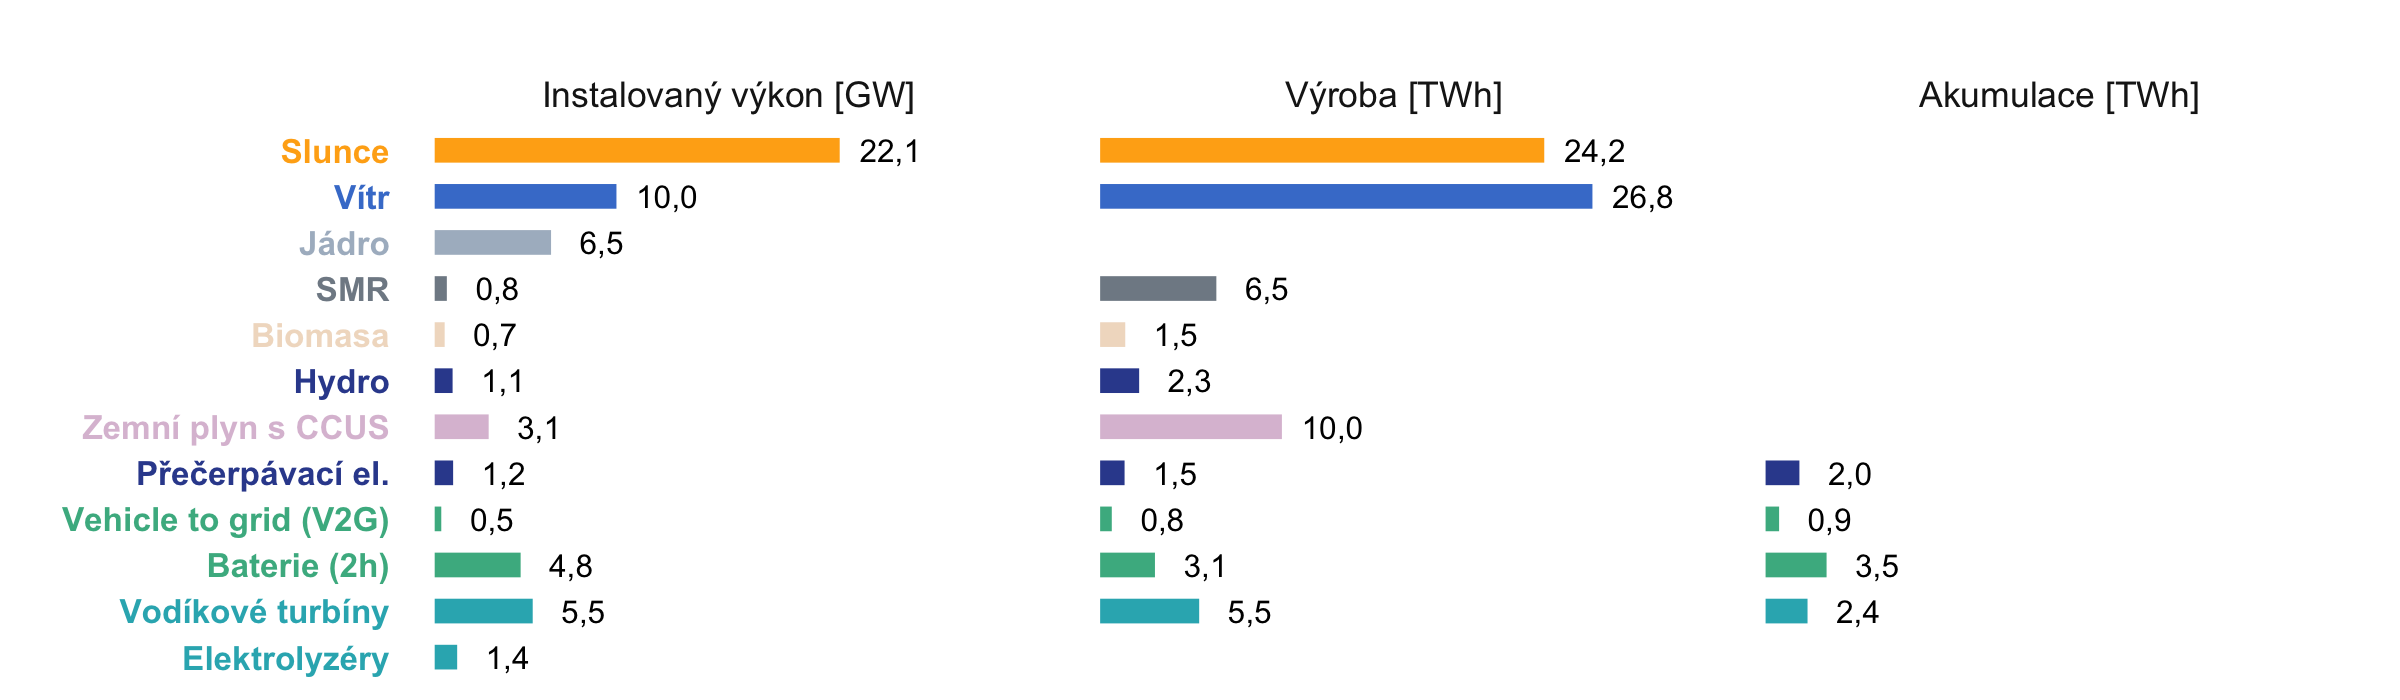

Warning message:
“Removed 9 rows containing missing values or values outside the scale range
(`geom_col()`).”
Warning message:
“Removed 9 rows containing missing values or values outside the scale range
(`geom_text()`).”


stat                     val  
1 load_TWh                 107.5
2 net_import_TWh            -7.7
3 curtailment_TWh            2.0
4 ratio_RES_%               43.5
5 ratio_nuclear_%           39.9
6 system_costs_EUR_per_MWh  96.4
7 production_TWh           125.9

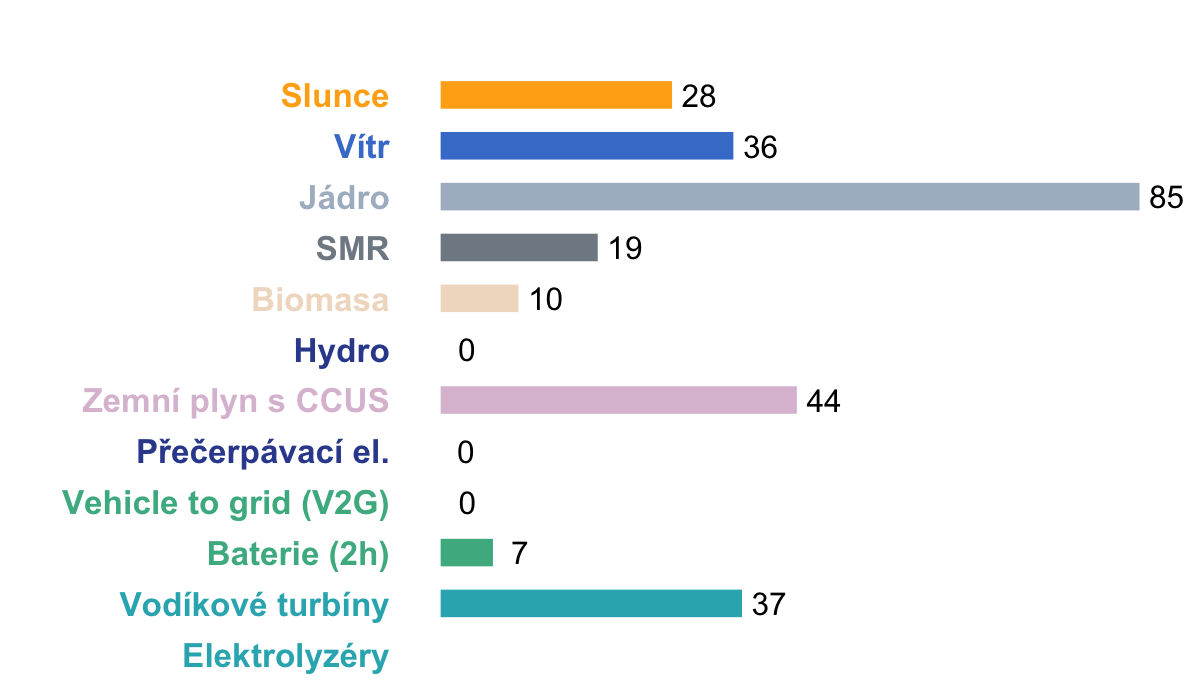

In [35]:
options(repr.plot.width = 12, repr.plot.height = 3.5)

dashboard_filtered$stat <- factor(dashboard_filtered$stat,
  levels = c("capacity_GW", "production_TWh", "charged_TWh"),
  labels = c("Instalovaný výkon [GW]", "Výroba [TWh]", "Akumulace [TWh]")
)

dashboard_filtered |>
  ggplot(aes(source, val)) +
  geom_col(
    aes(fill = source),
    colour = "#ffffff",
    # width = 0.4,
    width = 0.6,
  ) +
  geom_text(
    aes(
      x = source,
      y = val + 1,
      label = format(round(val, 1), decimal.mark = ",")
    ),
    hjust = 0,
    stat = "identity",
    size = 4
  ) +
  coord_flip() +
  scale_fill_manual(
    limits = source_limits,
    labels = source_labels,
    values = source_pallete,
  ) +
  scale_x_discrete(
    "",
    limits = source_limits,
    labels = source_labels
  ) +
  scale_y_continuous(
    "",
    breaks = c(),
    limits = c(0, 32),
    position = "right",
  ) +
  facet_grid(cols = vars(stat)) +
  theme(
    panel.grid.major.y = element_blank(), # remove the vertical grid lines
    legend.position = "none",
    text = element_text(size = 16),
    axis.text.y = element_text(size = 12, colour = source_pallete, face = "bold"),
  )

if (save_svgs) {
  ggsave("reference-production.svg", width = 12, height = 3.5, create.dir = TRUE)
}

options(repr.plot.width = 6, repr.plot.height = 3.5)

dashboard |>
  filter(stat == "totex_bil_CZK") |>
  ggplot(aes(source, val)) +
  geom_col(
    aes(fill = source),
    colour = "#ffffff",
    # width = 0.4,
    width = 0.6,
  ) +
  geom_text(
    aes(
      x = source,
      y = val + 1,
      label = format(round(val, 0), decimal.mark = ",")
    ),
    hjust = 0,
    stat = "identity",
    size = 4
  ) +
  coord_flip() +
  scale_fill_manual(
    limits = source_limits,
    labels = source_labels,
    values = source_pallete,
  ) +
  scale_x_discrete(
    "",
    limits = source_limits,
    labels = source_labels
  ) +
  scale_y_continuous(
    "",
    breaks = c(),
    position = "right",
  ) +
  theme(
    panel.grid.major.y = element_blank(), # remove the vertical grid lines
    legend.position = "none",
    text = element_text(size = 16),
    axis.text.y = element_text(size = 12, colour = source_pallete, face = "bold"),
  )

if (save_svgs) {
  ggsave("reference-costs.svg", width = 6, height = 3.5, create.dir = TRUE)
}

dashboard_summary$val <- round(dashboard_summary$val, digits = 1)
dashboard_summary


In [36]:
source_limits_table <- c(
  "solar",
  "onshore",
  "nuclear",
  "smr",
  "b_CHP",
  "hydro",
  "gas_ccgt_ccs",
  "hydrogen",
  "short"
)

additional_table <- c(
  "production_TWh",
  "net_import_TWh",
  "curtailment_TWh"
)

dashboard_table <- dashboard_filtered |>
  filter(stat != "Akumulace [TWh]") |>
  filter(source %in% source_limits_table)

dashboard_table$val <- round(dashboard_table$val, digits = 1)
dashboard_table <- dashboard_table |>
  pivot_wider(names_from = stat, values_from = val)
dashboard_table[match(source_limits_table, dashboard_table$source),]


dashboard_summary$val <- round(dashboard_summary$val, digits = 1)
dashboard_summary <- dashboard_summary |>
  filter(stat %in% additional_table)
dashboard_summary[match(additional_table, dashboard_summary$stat),]


source       Instalovaný výkon [GW] Výroba [TWh]
1 solar        22.1                   24.2        
2 onshore      10.0                   26.8        
3 nuclear       6.5                   43.7        
4 smr           0.8                    6.5        
5 b_CHP         0.7                    1.5        
6 hydro         1.1                    2.3        
7 gas_ccgt_ccs  3.1                   10.0        
8 hydrogen      5.5                    5.5        
9 short         6.5                    5.4

stat            val  
1 production_TWh  125.9
2 net_import_TWh   -7.7
3 curtailment_TWh   2.0